# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [84]:
#!pip install folium

In [85]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [87]:
# тут можно выпендриваться и делать через kaggle API, но раз не просят, то зачем?).
taxi_holder = pd.read_csv('train.csv')
taxi = taxi_holder.copy()
taxi_holder.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [88]:
taxi.drop('dropoff_datetime', axis=1, inplace=True)
taxi.pickup_datetime = pd.to_datetime(taxi.pickup_datetime)
taxi.pickup_datetime.dtype

dtype('<M8[ns]')

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

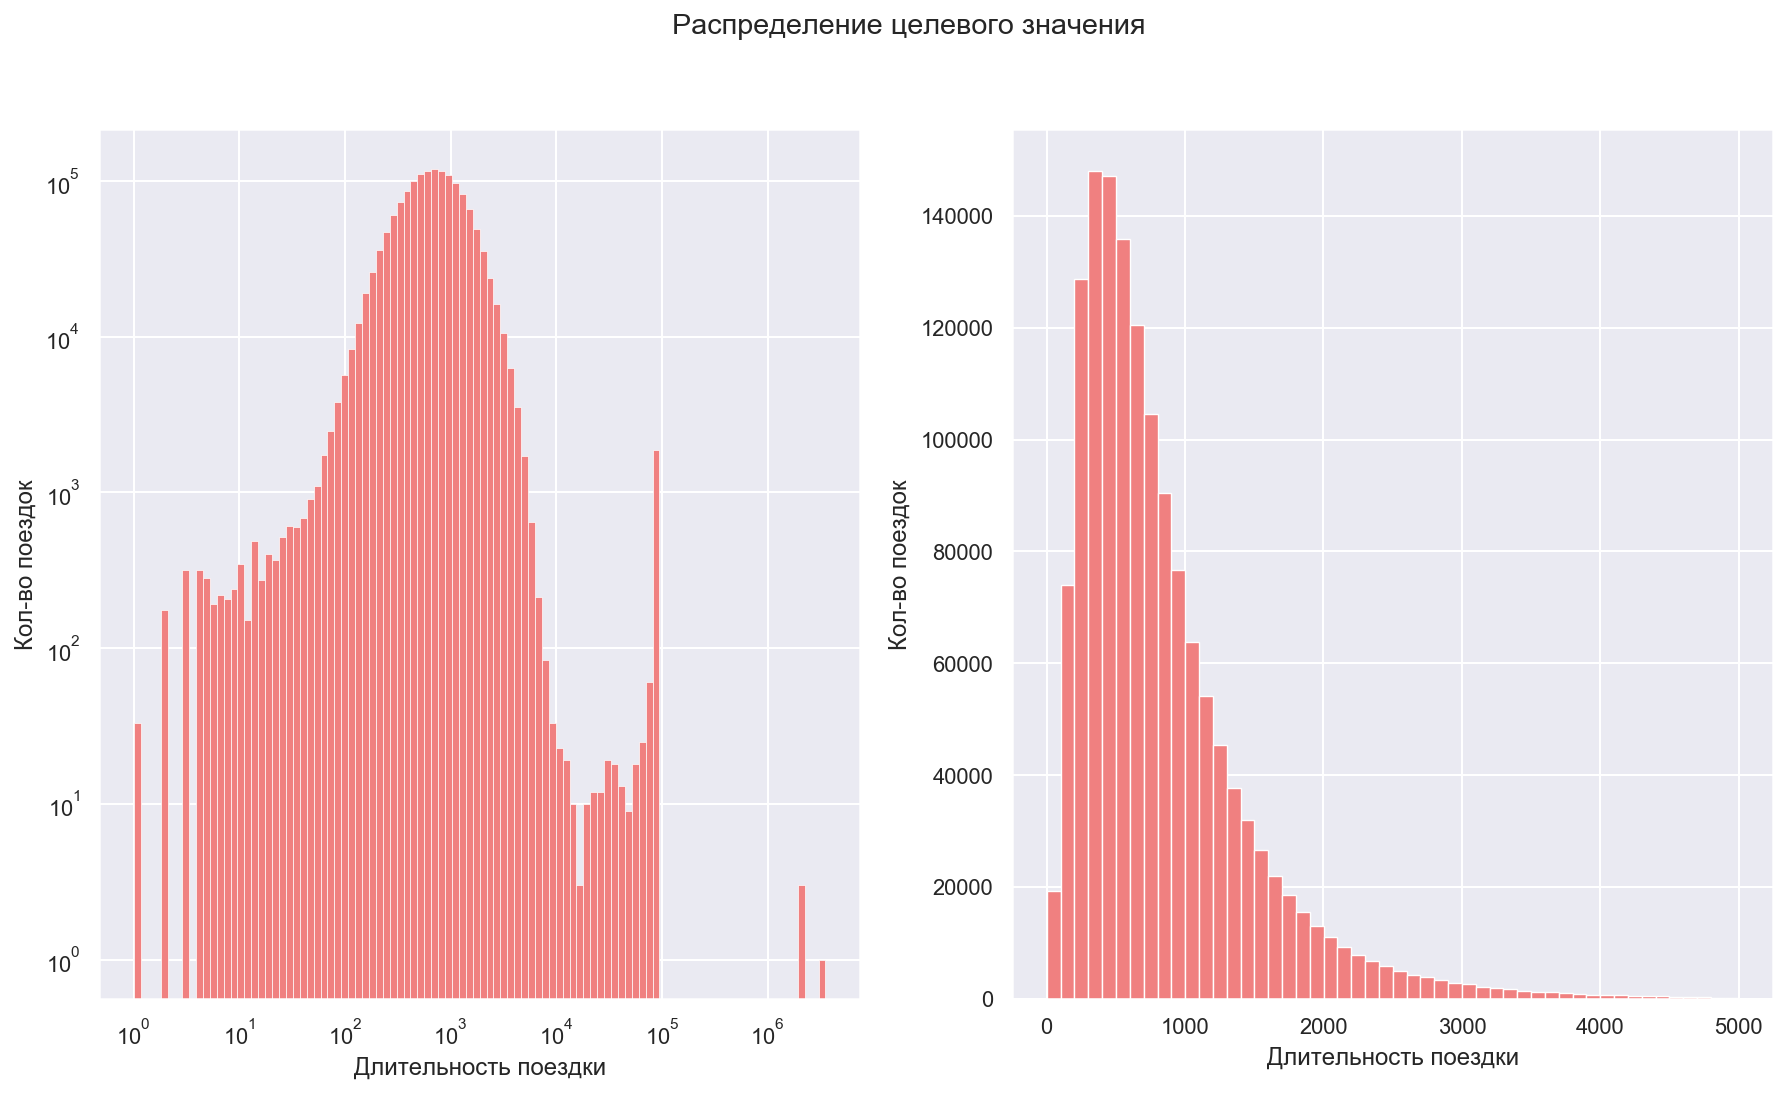

In [89]:
%config InlineBackend.figure_format = 'retina'
fig , ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 8))
sns.histplot(data = taxi, x = 'trip_duration', bins=100, ax=ax[0],
                 color='lightcoral', log_scale=(True, True), alpha=1)
sns.histplot(data = taxi[taxi.trip_duration < 5000], x = 'trip_duration', bins=50, ax=ax[1],
                 color='lightcoral', alpha=1)
plt.rcParams['figure.figsize'] = 16, 10
plt.rcParams['font.size'] = 12
ax[0].set_xlabel("Длительность поездки")
ax[0].set_ylabel("Кол-во поездок")
ax[1].set_xlabel("Длительность поездки")
ax[1].set_ylabel("Кол-во поездок")
fig.suptitle('Распределение целевого значения')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: По первому графику можно увидеть, что имеют место как чрезвычайно долгие поездки, так и аномально короткие. Однако второй график указывает на то, что большая часть данных лежит между ~300 и 1000 секундами. До 5 тысяч наблюдается обычное распределение, что показывает второй график. 

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: В ответе на данный вопрос можно отталкиваться от разницы этих двух метрик. RMSLE сильнее штрафует за занижение, что достаточно важно при анализе именно поездок такси. Более того, выбранная метрика смотрит на порядок ошибки, сильнее штрафуя их, нежели саму величину, что крайне важно для имеющихся в данных длительных поездках.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: 

Отталкиваться будем от следующего преобразования: $$ a(x_i) = e^{\hat{a}(x_i)} - 1 \rightarrow \hat{a}(x_i) = \log(a(x_i) + 1) $$. Это наиболее простой вариант, ведь из этого напрямую следуют следующие вычисления:
$$ \text{RMSLE}(X, y, a) = [...] = \sqrt{\frac{1}{\ell} \sum_{i=1}^{\ell} (\hat{y}(x_i) - \hat{a}(x_i))^2} = \text{RMSE}(X, \hat{y}, \hat{a})$$
Таким образом, доказана эквивалентность оптимизации RMSLE для $a$ оптимизации MSE для $\hat{a}$!

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


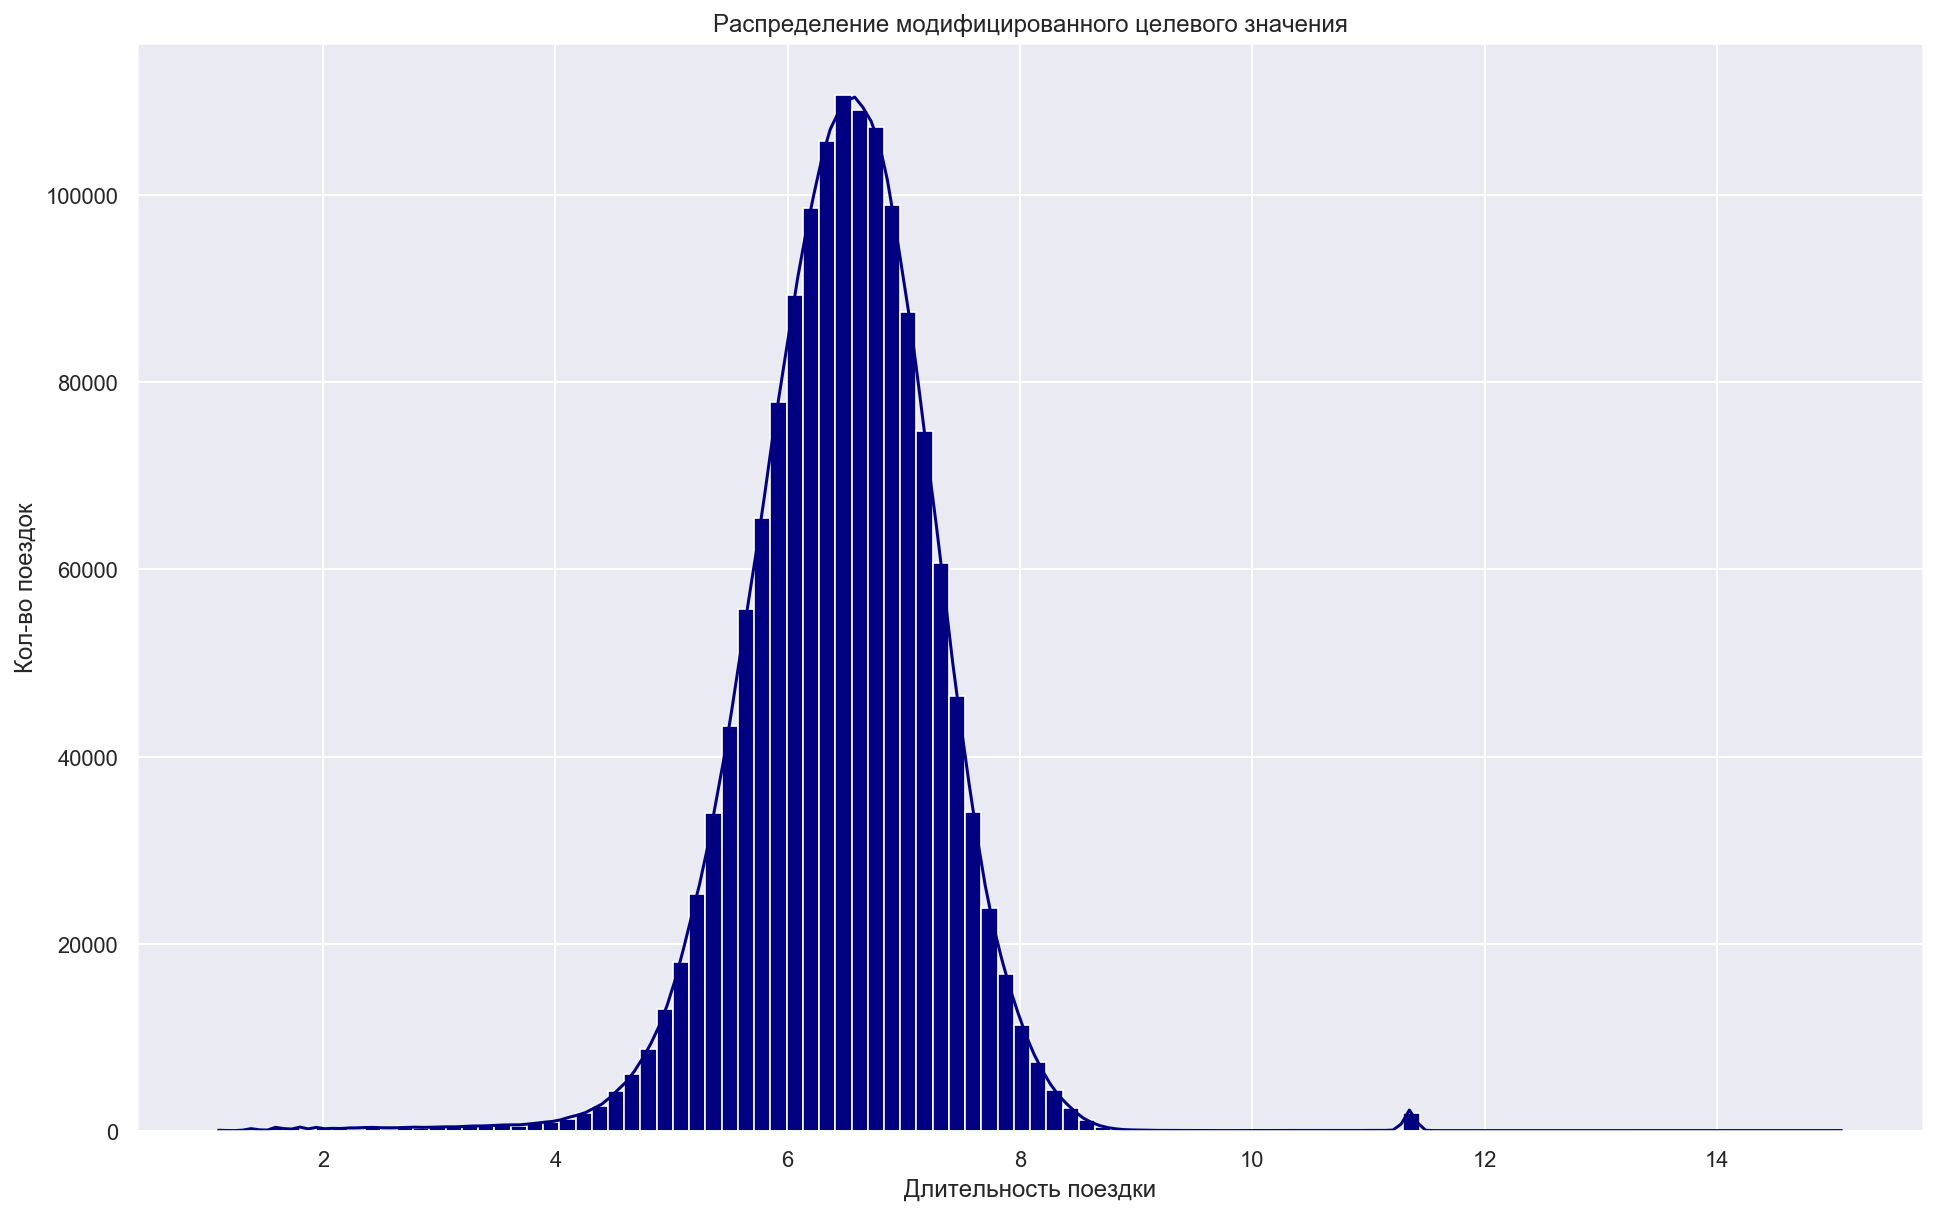

In [90]:
taxi['log_trip_duration'] = np.log1p(taxi.trip_duration + 1)
g = sns.histplot(data = taxi, x = 'log_trip_duration', 
                 bins=100, alpha=1, kde=True, color="navy").set_title('Распределение модифицированного целевого значения')
plt.rcParams['figure.figsize'] = 16, 10
plt.rcParams['font.size'] = 12
plt.xlabel("Длительность поездки")
plt.ylabel("Кол-во поездок")
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [91]:
from sklearn.metrics import mean_squared_error
best_const = taxi.log_trip_duration.mean()
mse_start = mean_squared_error(taxi.log_trip_duration, [best_const] * taxi.shape[0], squared=False)
mse_start

0.7923870986444397

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [92]:
taxi['year_day'] = taxi.pickup_datetime.dt.dayofyear

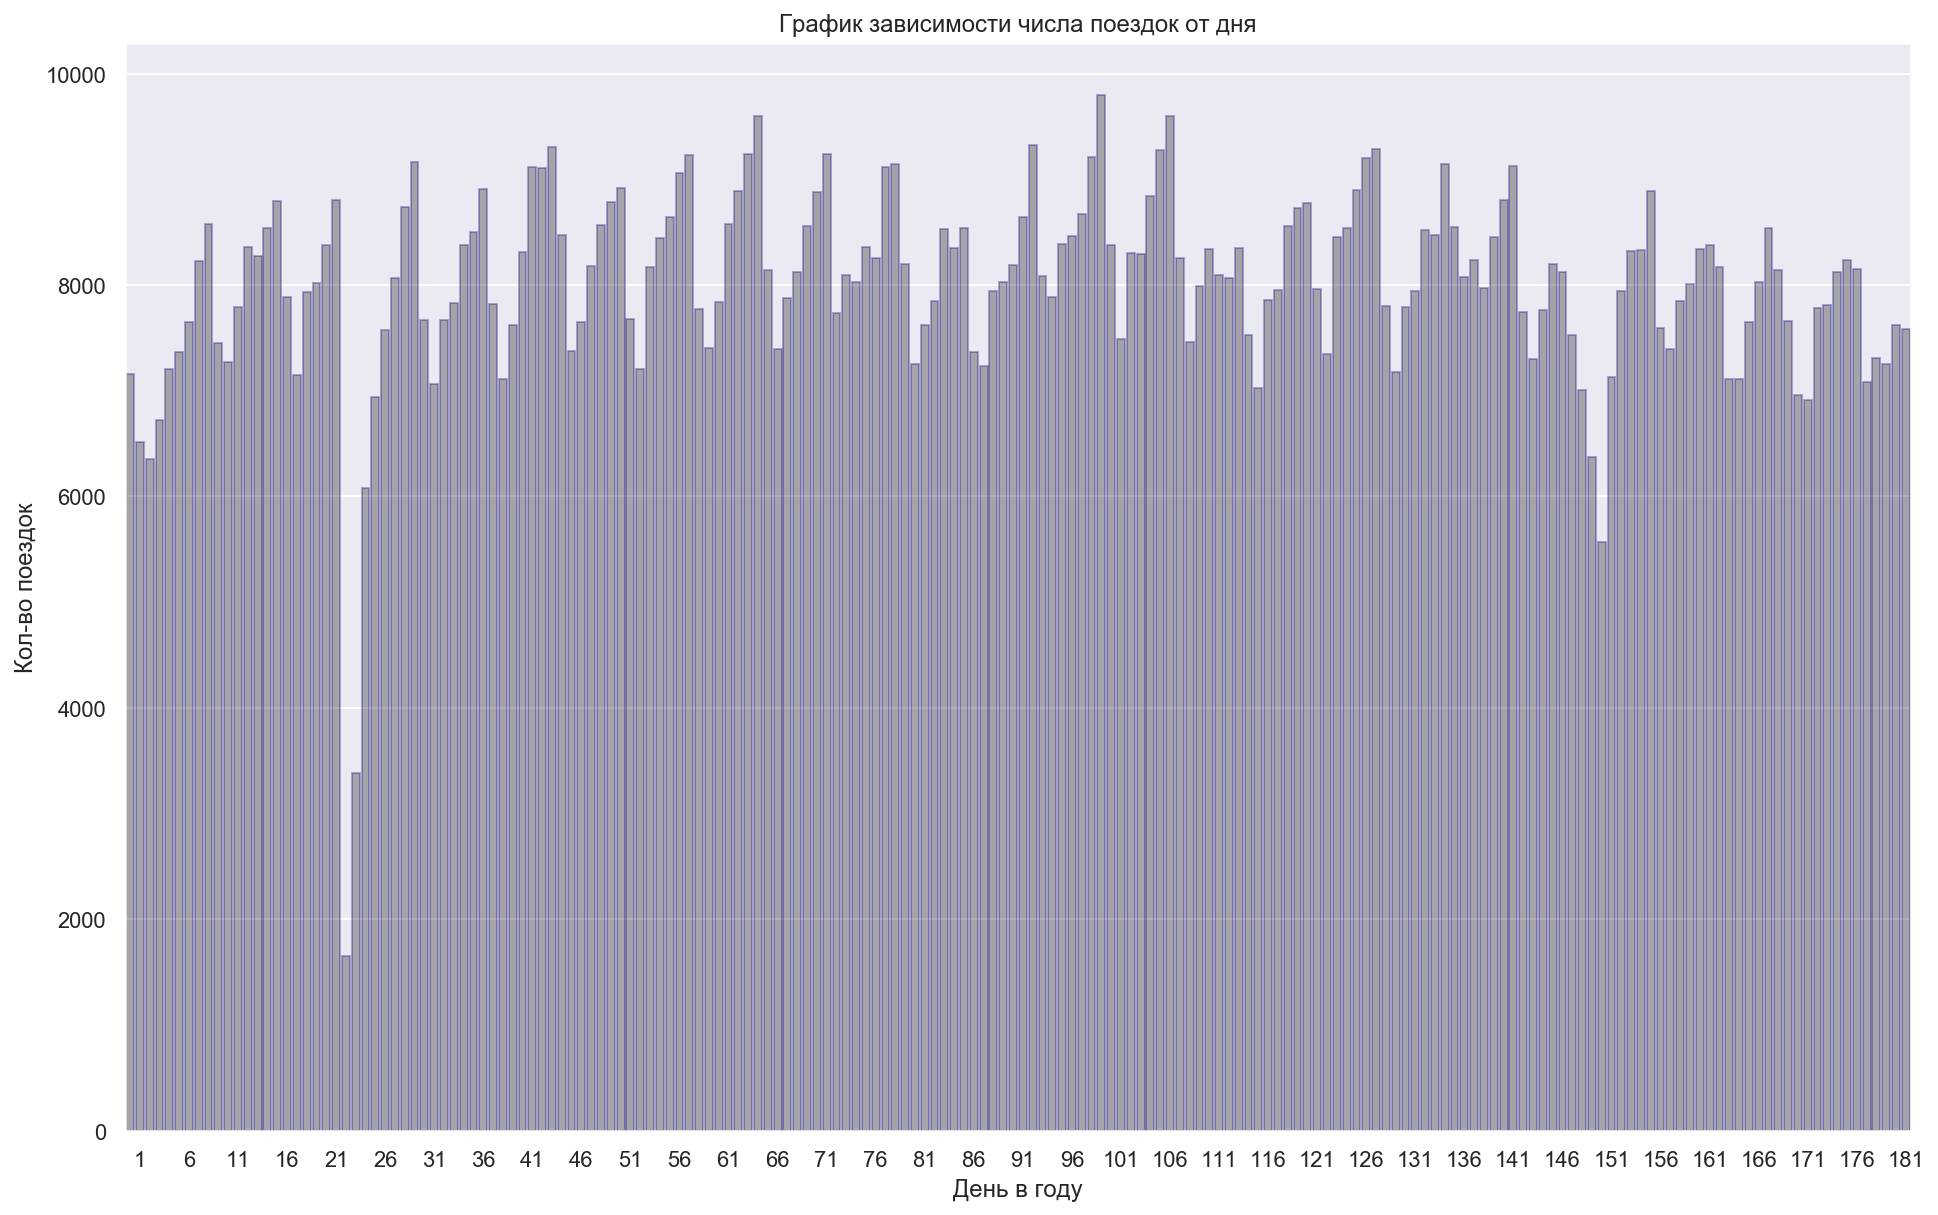

In [93]:
gig = sns.countplot(x = 'year_day', data=taxi.sort_values('year_day'), 
                    facecolor=(0, 0, 0, 0), alpha=0.3, edgecolor='navy')
plt.title('График зависимости числа поездок от дня')
plt.xticks(range(1, len(set(taxi.year_day)), 5), list(set(taxi.year_day))[::5])
plt.rcParams['figure.figsize'] = 16, 10
plt.rcParams['font.size'] = 12
plt.xlabel("День в году")
plt.ylabel("Кол-во поездок")
#gig.xaxis.set_major_formatter(plt.NullFormatter())
plt.show()


**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

**Ответ**: Два аномальных дня - 23 и 24 января 2016. В эти дни был снежный шторм, который подтолкнул власти к запрету автомобильного движения в эти дни.

In [94]:
print('Two anomalous days were', list(taxi.year_day.value_counts(ascending=True)[0:2].index))

Two anomalous days were [23, 24]


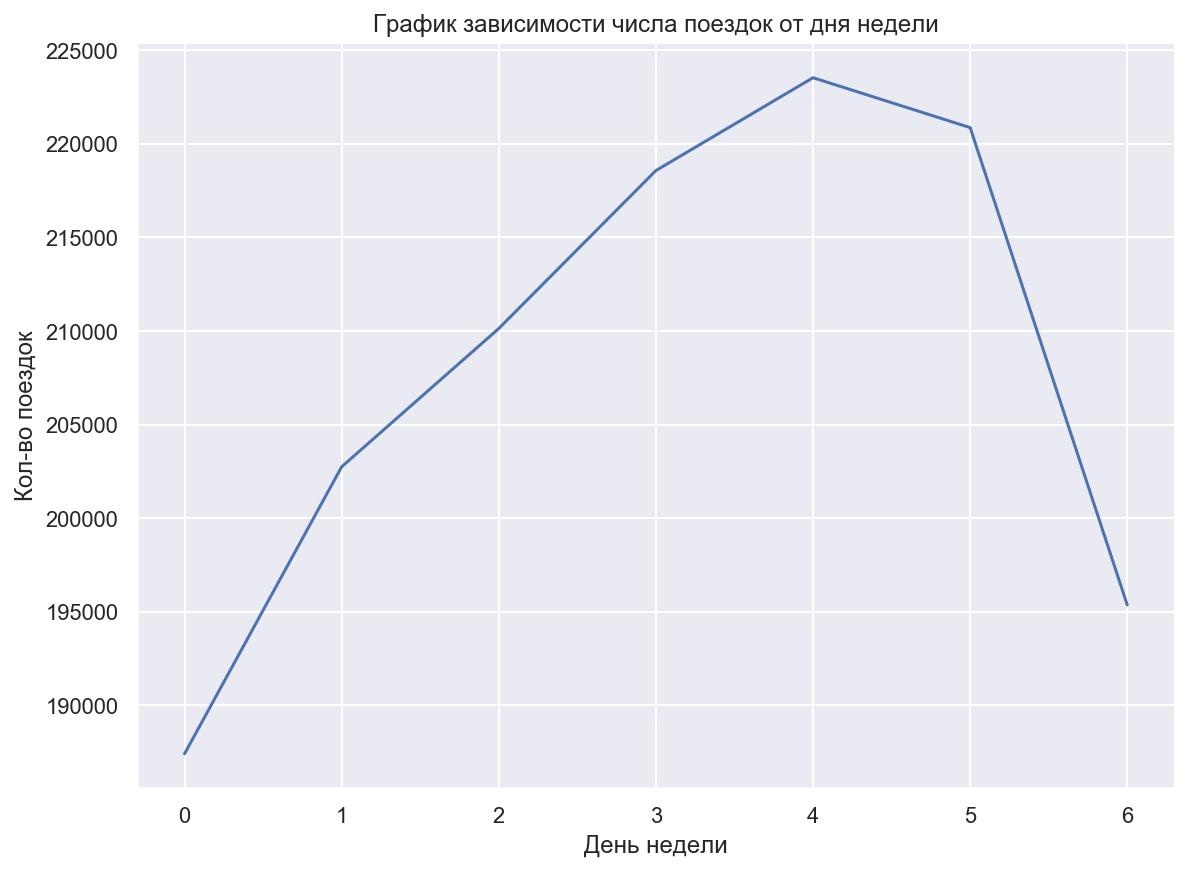

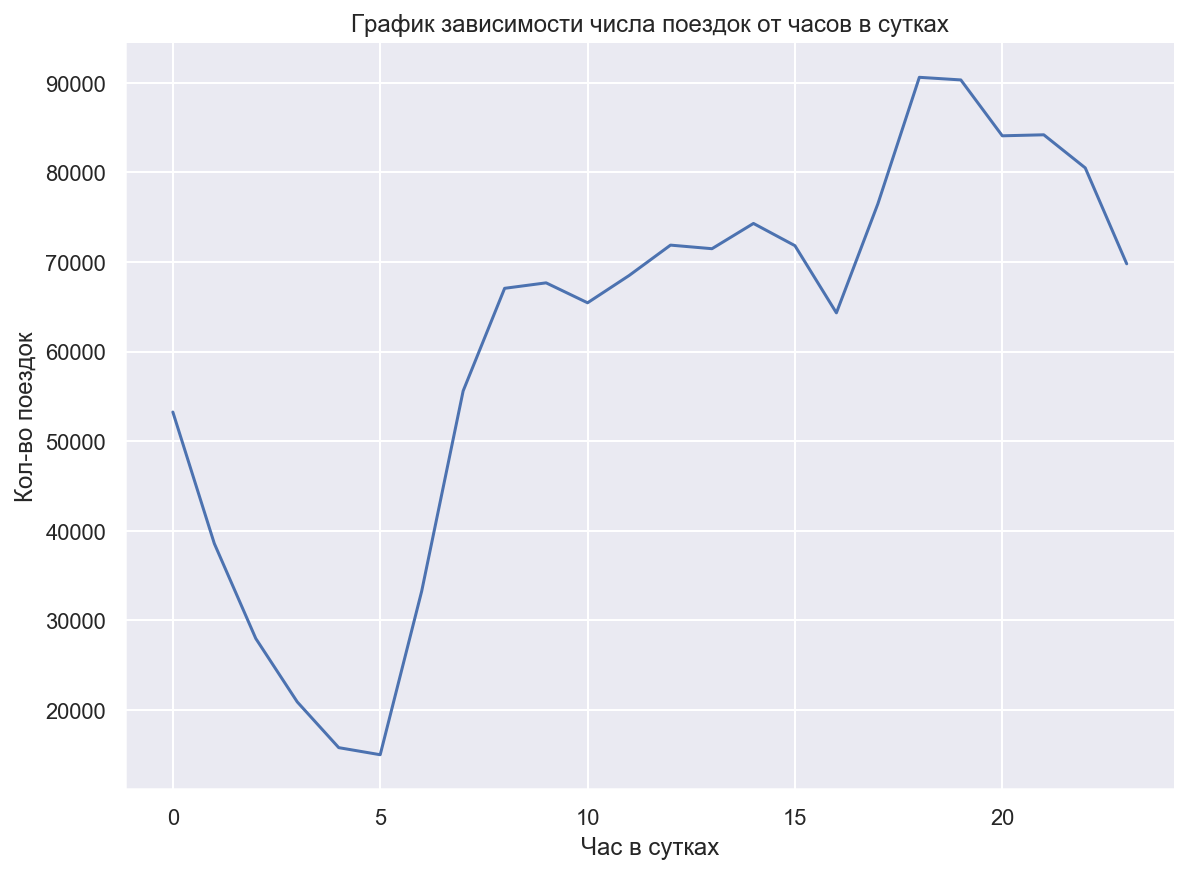

In [298]:
sns.relplot(x = taxi['pickup_datetime'].dt.dayofweek.value_counts().index, 
                y = taxi['pickup_datetime'].dt.dayofweek.value_counts(), 
                kind='line', height=6, aspect=1.4).set(title='График зависимости числа поездок от дня недели')
plt.rcParams['font.size'] = 12
plt.xlabel("День недели")
plt.ylabel("Кол-во поездок")
sns.relplot(x = taxi['pickup_datetime'].dt.hour.value_counts().index, 
                y = taxi['pickup_datetime'].dt.hour.value_counts(), 
                kind='line', height=6, aspect=1.4).set(title='График зависимости числа поездок от часов в сутках')
plt.rcParams['font.size'] = 12
plt.xlabel("Час в сутках")
plt.ylabel("Кол-во поездок")
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [309]:
def magic_count(first_col, second_col):
    tmp = pd.concat([first_col, second_col], axis=1)
    tmp.columns = ['month', 'sec']
    return  pd.DataFrame(tmp.groupby(['month', 'sec'], as_index=False).size())

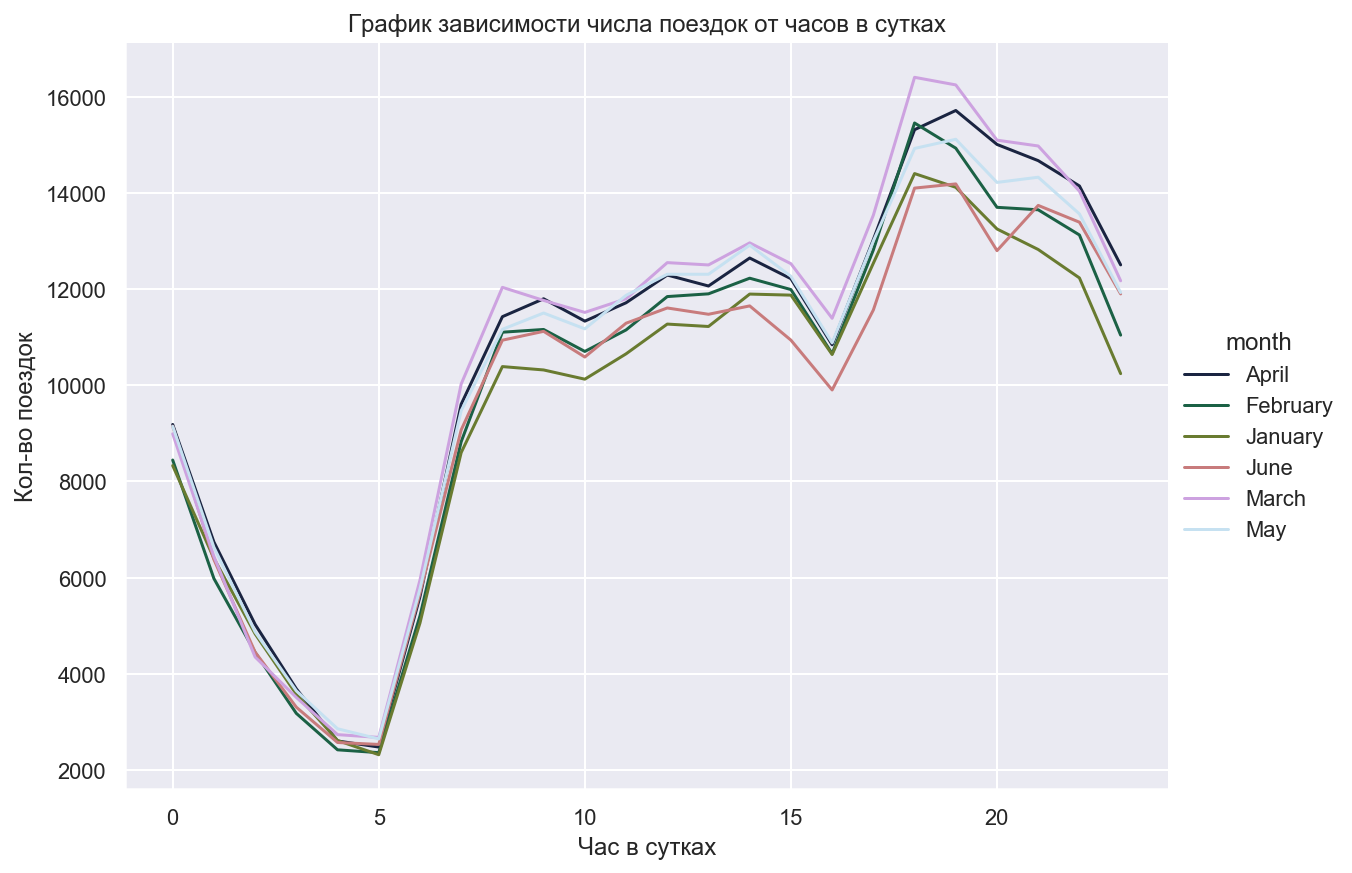

In [310]:
fir_plot = magic_count(taxi['pickup_datetime'].dt.month_name(), taxi['pickup_datetime'].dt.hour)
sns.relplot(x = fir_plot.sec, y = fir_plot['size'], kind='line', height=6, aspect=1.4, hue=fir_plot.month, 
    palette=sns.color_palette("cubehelix")).set(title='График зависимости числа поездок от часов в сутках')
plt.rcParams['font.size'] = 12
plt.xlabel("Час в сутках")
plt.ylabel("Кол-во поездок")
plt.show()

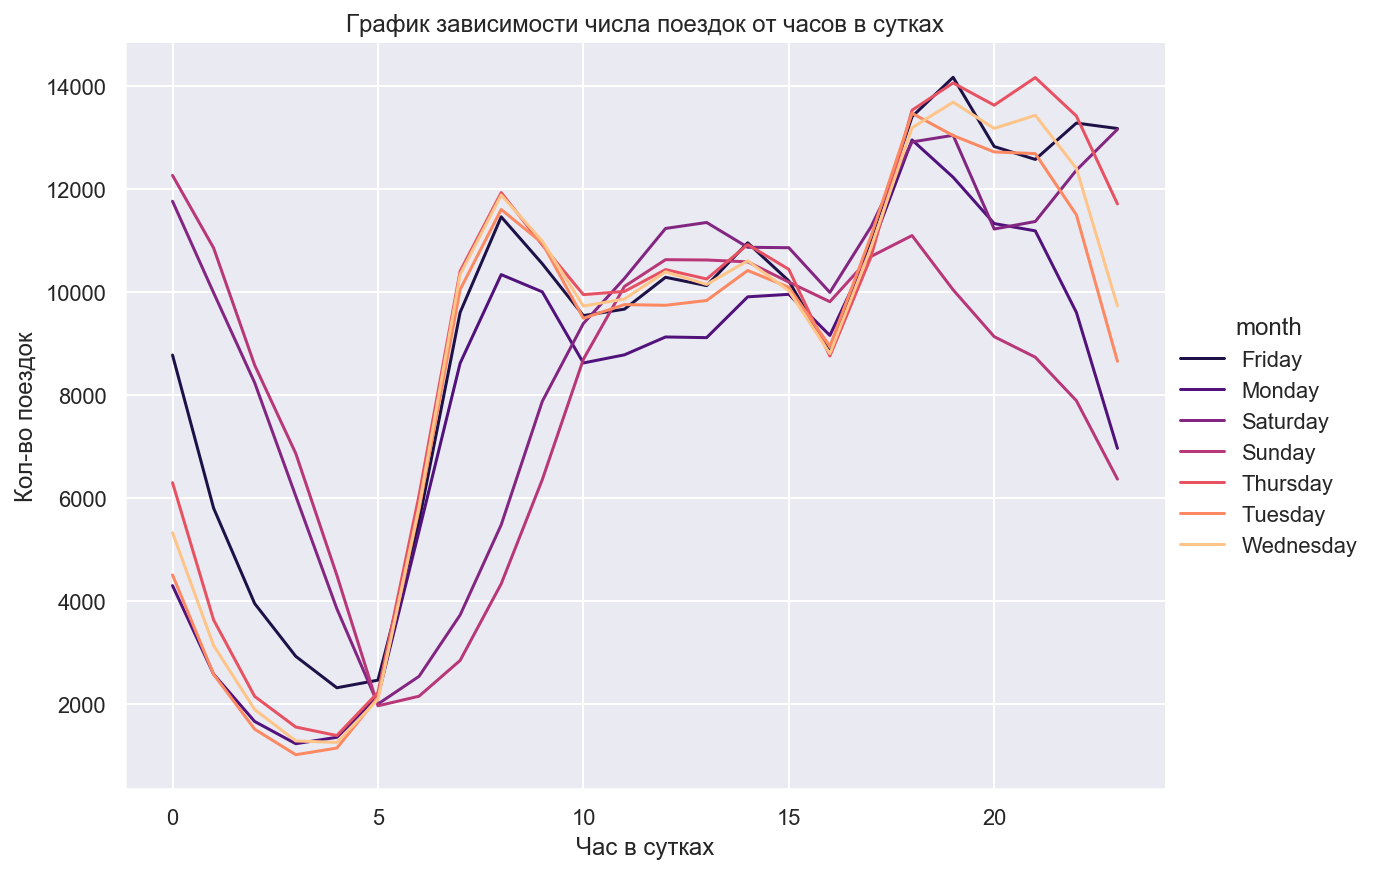

In [312]:
sec_plot = magic_count(taxi['pickup_datetime'].dt.day_name(), taxi['pickup_datetime'].dt.hour)
sns.relplot(x = sec_plot.sec, y = sec_plot['size'], kind='line', height=6, aspect=1.4, hue=sec_plot.month, 
    palette=sns.color_palette("magma", n_colors=7)).set(title='График зависимости числа поездок от часов в сутках')
plt.rcParams['font.size'] = 12
plt.xlabel("Час в сутках")
plt.ylabel("Кол-во поездок")
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: Разбирая график с часами в сутках по месяцам, можно убедиться в минимальной загруженности дорог в 4-5 утра. Последнее особенно ярко контрастирует с резким ростом после 5 утра, выходящим на плато с ~9 и до 15 часов уровня 10-12 тысяч поездок. Пик загруженности же достигается в 18-19 часов, после чего происходит плавное падение.
Если обсуждать второй график, то можно наблюдать меньшую синхронизацию дней, чем месяцов. Тем не менее, характер повторяется, хотя значения и разразнятся (логично, ведь из обычных наблюдений можно понять, что в одни дни больше машин на улицах, чем в другие). Точно такое же падение в начале дня и достижение минимума, после чего рост и плато и уход на максимум.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [99]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(taxi, taxi.log_trip_duration, test_size=0.3, random_state=10)

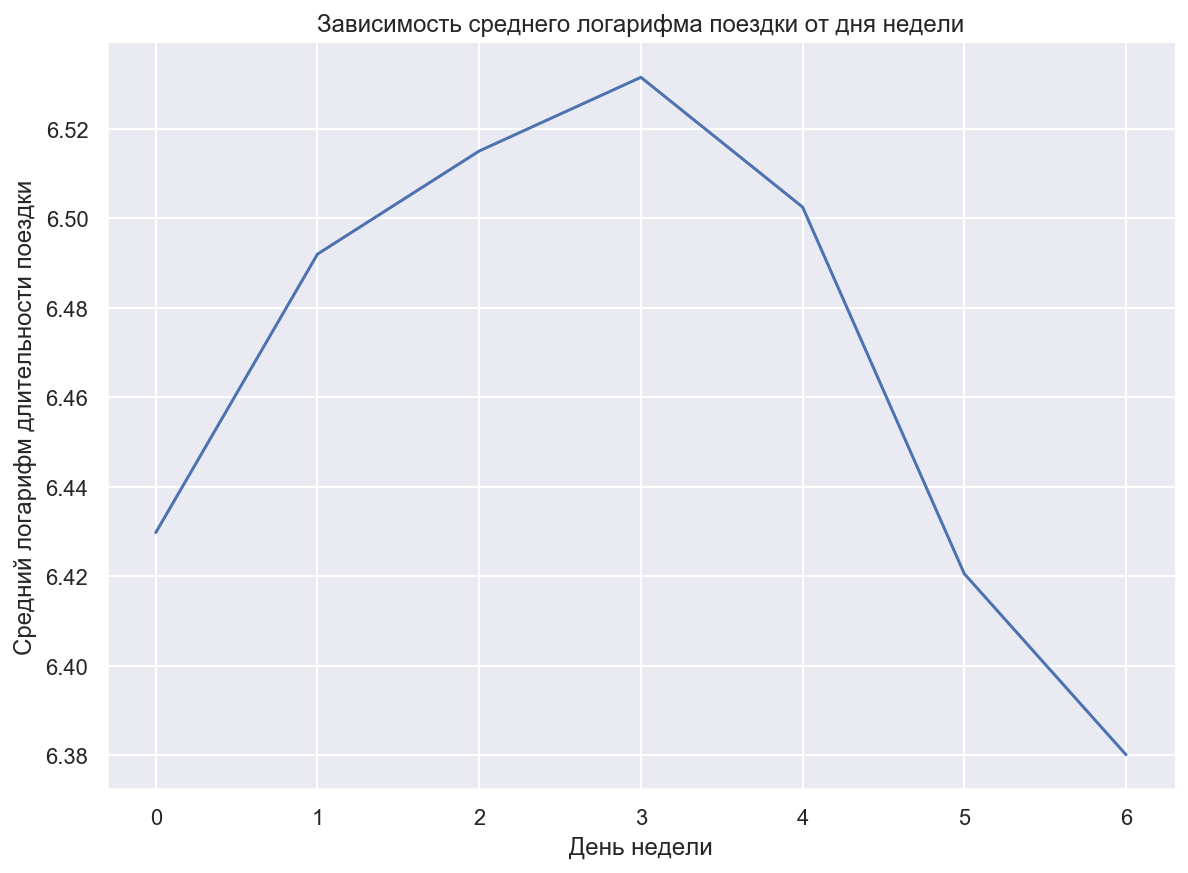

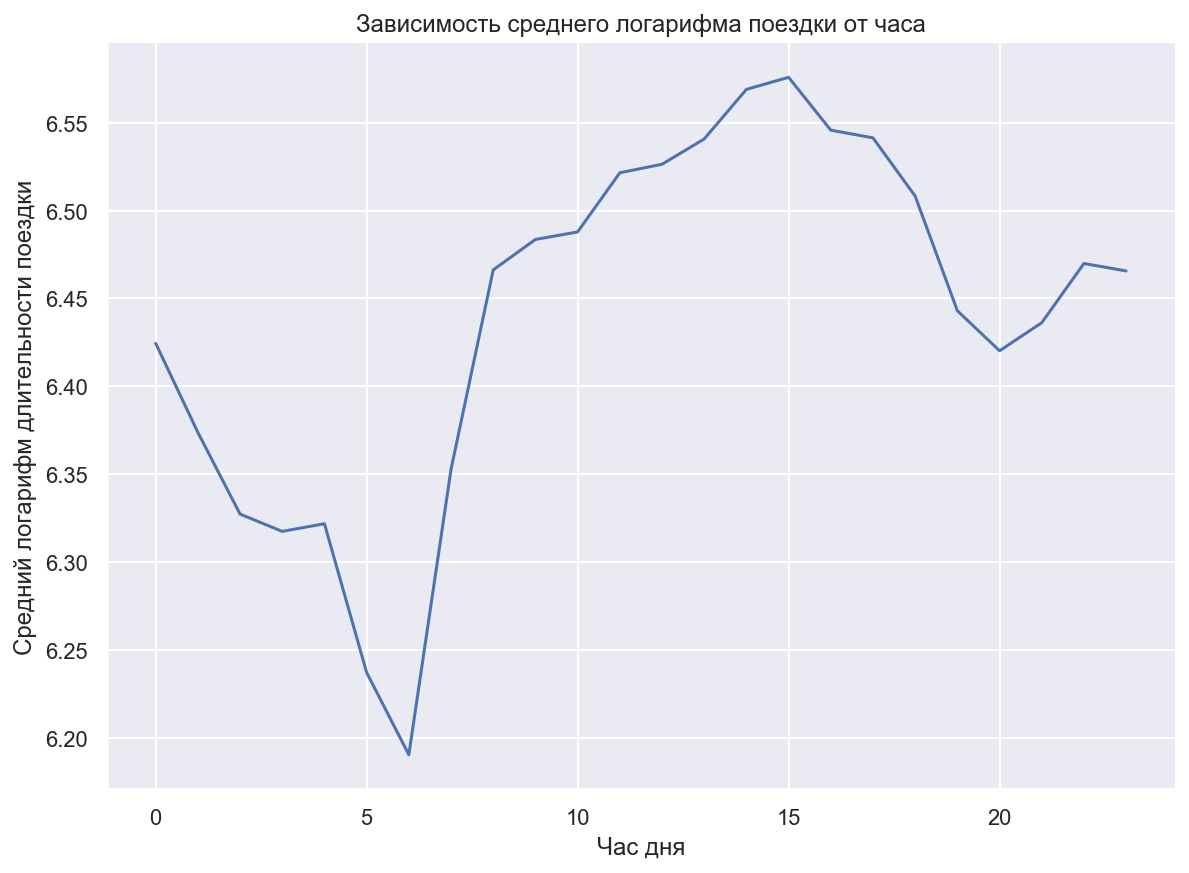

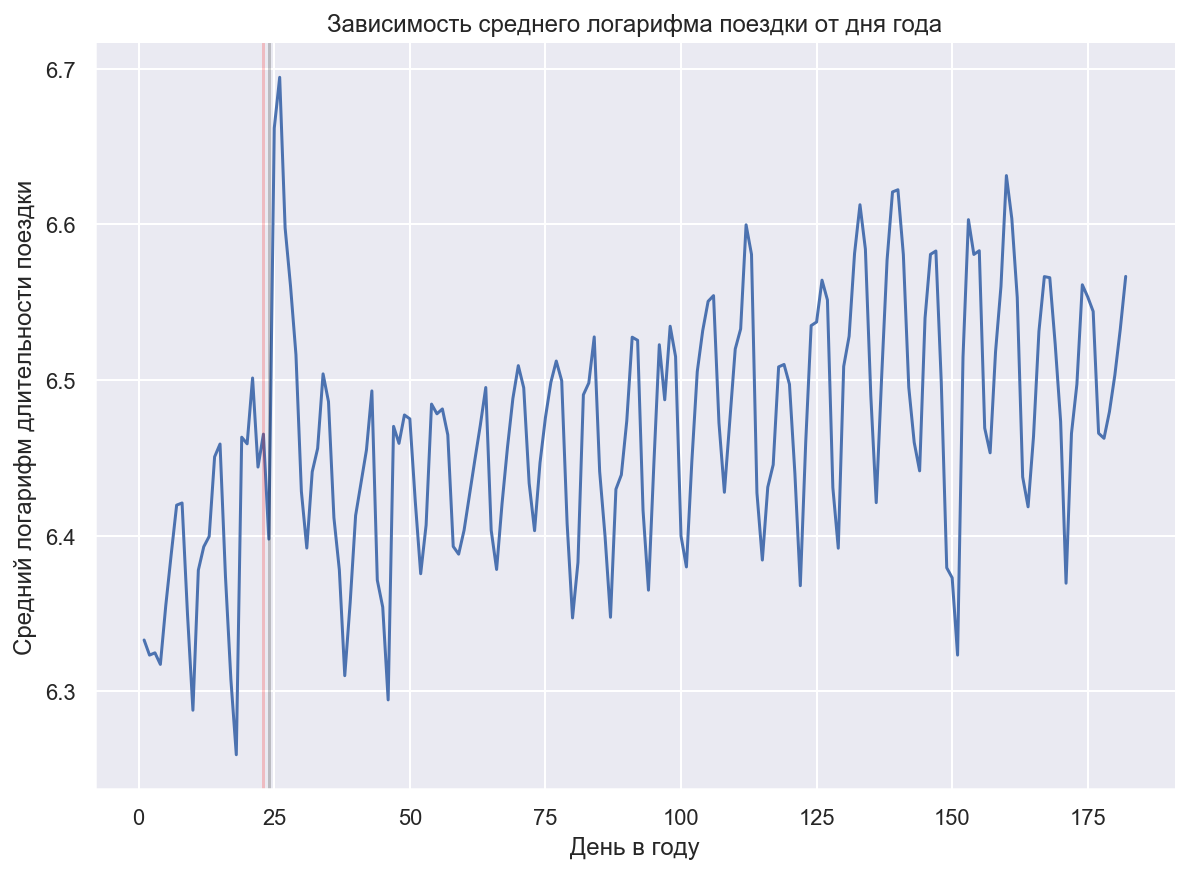

In [304]:
tmp_one = x_train.groupby(by=x_train['pickup_datetime'].dt.dayofweek).mean()
tmp_two = x_train.groupby(by=x_train['pickup_datetime'].dt.hour).mean()
tmp_three = x_train.groupby(by=x_train['year_day']).mean()

g = sns.relplot(x = tmp_one.index, y = tmp_one.log_trip_duration, kind='line', height=6, 
                aspect=1.4)
plt.title('Зависимость среднего логарифма поездки от дня недели')
gg = sns.relplot(x = tmp_two.index, y = tmp_two.log_trip_duration, kind='line', height=6, 
                 aspect=1.4)
plt.title('Зависимость среднего логарифма поездки от часа')
ggg = sns.relplot(x = tmp_three.index, y = tmp_three.log_trip_duration, kind='line', height=6, 
                  aspect=1.4)
plt.title("Зависимость среднего логарифма поездки от дня года")
plt.rcParams['font.size'] = 12
g.set_axis_labels("День недели", "Средний логарифм длительности поездки")
gg.set_axis_labels("Час дня", "Средний логарифм длительности поездки")
ggg.set_axis_labels("День в году", "Средний логарифм длительности поездки")
plt.axvline(x=23, color='red', alpha=0.2)
plt.axvline(x=24, color='black', alpha=0.2)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: Да, можно увидеть крайне схожие результаты графиков для таргета и для количества поездок. Количество поездок влияет на загруженность дорог, а значит и на время преодоления любого фиксированного по расстоянию маршрута. В аномальные дни таргет, что отчетливо видно на графике, достигает локальный, но не глобальный минимум. Это логично, так как хоть и упало количество поездок, однако и длительность должна была снизится из-за затрудненного движения. Анализируя тренд, необходимо вспомнить о графике для дней недели, где виден рост и дальнейшее падение таргета. Подобное поведение должны быть +- похожим для каждой недели, а значит, своего рода синусоида, наблюдающаяся на графике дней года, ожидаема. Однако нельзя не заметить растущий характер тренда: и пики, и падения медленно растут в значениях.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [101]:
def magic_update(df, main_df, hour, week_day, month):
    df['week_day'] = week_day
    df['month'] = month
    df['hour'] = hour
    anom_days = pd.DataFrame(main_df.year_day.value_counts(ascending=True)[0:2]).index
    df['anom_1'] = df.year_day == anom_days[0]
    df['anom_2'] = df.year_day == anom_days[1]
    return df

x_train = magic_update(x_train, taxi, x_train.pickup_datetime.dt.hour,
                       x_train.pickup_datetime.dt.day_name(), x_train.pickup_datetime.dt.month)
x_test = magic_update(x_test, taxi, x_test.pickup_datetime.dt.hour,
                       x_test.pickup_datetime.dt.day_name(), x_test.pickup_datetime.dt.month)
taxi = magic_update(taxi, taxi, taxi.pickup_datetime.dt.hour,
                       taxi.pickup_datetime.dt.day_name(), taxi.pickup_datetime.dt.month)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ**: К категориальным относятся те, где одно значение не является более хорошим/плохим, чем другое. К таким относятся следующик признаки: часы, дни недели, день года и месяц. Напротив, в численных признаках значения можно сравнивать. К ним относятся бинарные признаки аномальности даты.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [102]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical = ['hour', 'week_day', 'year_day', 'month']
numeric_features = ['anom_1', 'anom_2']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7832


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [103]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [104]:
show_circles_on_map(taxi.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [105]:
show_circles_on_map(taxi.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ**: Первая - Аэропорт Кеннеди, вторая - аэропорт LaGuardia (в дальнейем Гварии)

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [106]:
from haversine import haversine_vector
taxi['haversine'] = haversine_vector(
    list(zip(taxi.pickup_latitude.tolist(), taxi.pickup_longitude.tolist())),
    list(zip(taxi.dropoff_latitude.tolist(),taxi.dropoff_longitude.tolist())), 'km')

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [107]:
taxi['log_haversine'] = np.log1p(taxi.haversine)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [108]:
print('The former, which equals', taxi.log_haversine.corr(taxi.log_trip_duration), 
      'correlates better than the latter, which is', taxi.haversine.corr(taxi.log_trip_duration))

The former, which equals 0.7508772990773142 correlates better than the latter, which is 0.5747978604351097


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [287]:
taxi['speed'] = taxi.haversine / taxi.trip_duration * 3600

In [291]:
taxi.speed.corr(taxi.log_trip_duration)

-0.01960046146740408

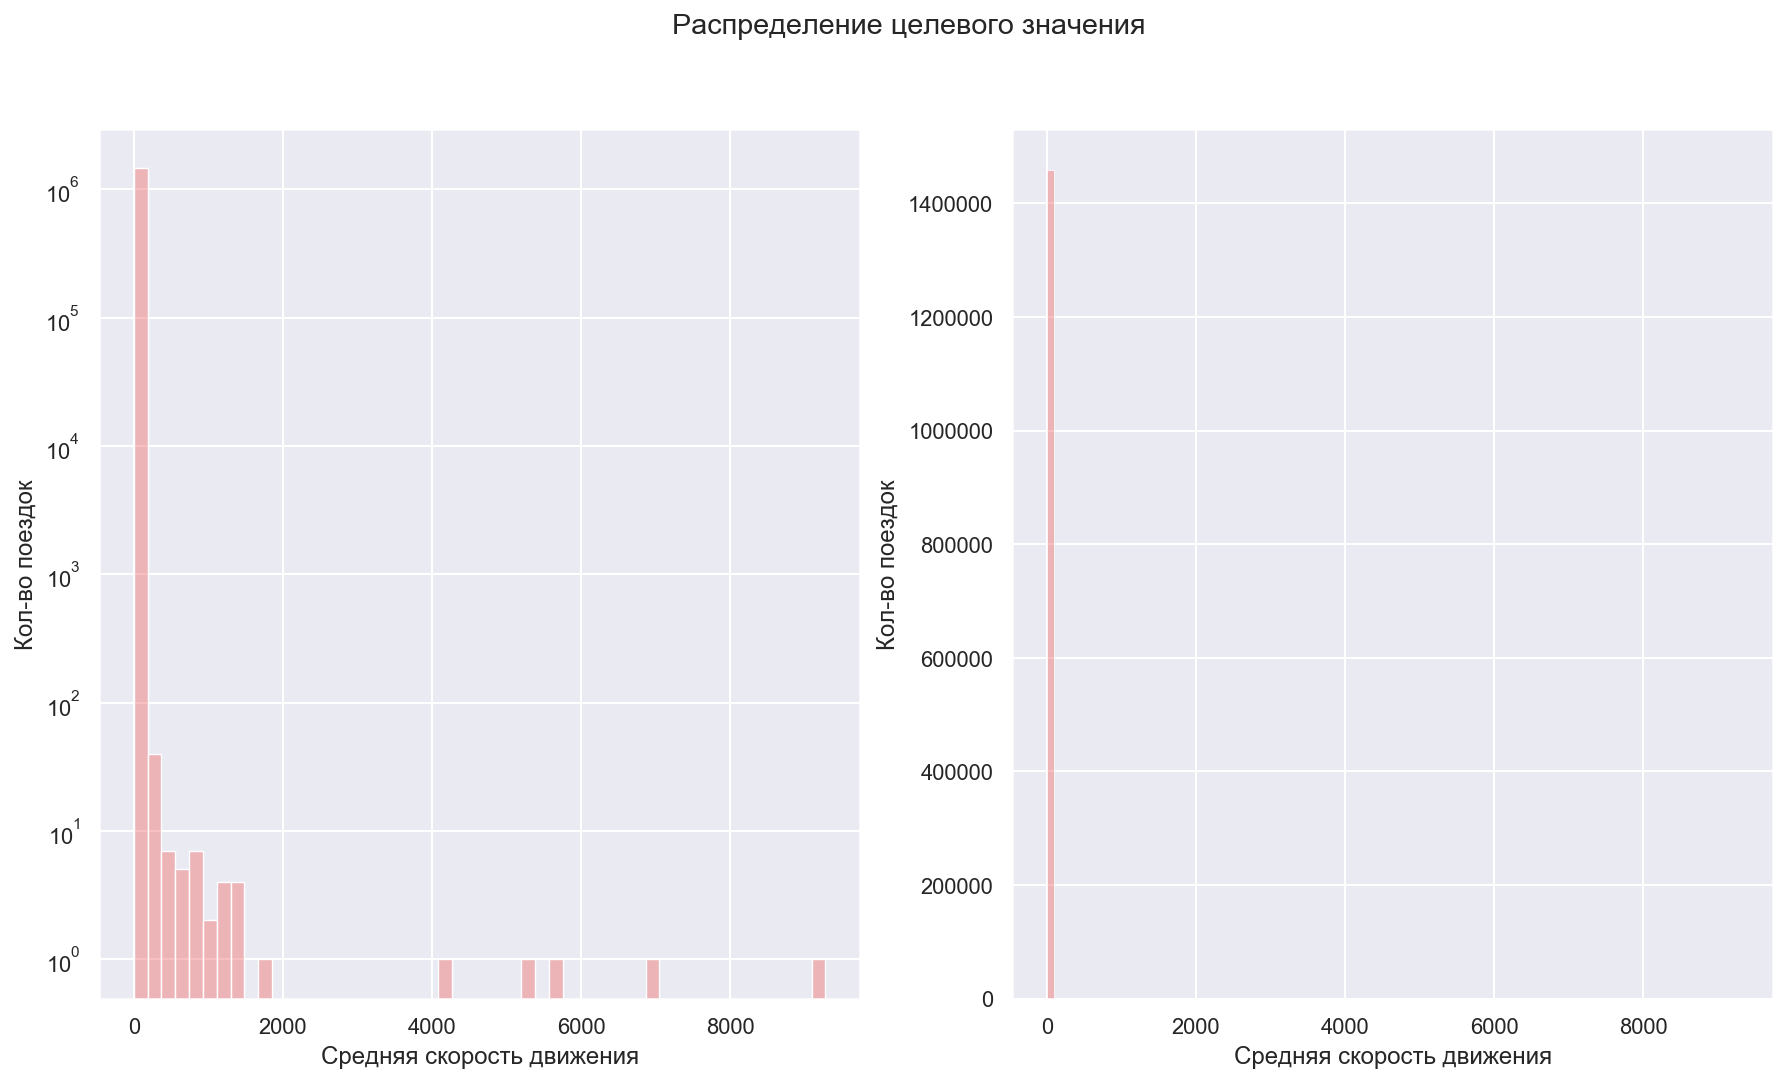

In [110]:
fig , ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 8))
sns.histplot(data = taxi, x = 'speed', ax=ax[0],
                 bins=50, alpha=0.5, color="lightcoral", log_scale=(False, True))
sns.histplot(data = taxi, x = 'speed', ax=ax[1],
                 bins=100, alpha=0.5, color="lightcoral")
plt.suptitle('Распределение целевого значения')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12
ax[0].set_xlabel("Средняя скорость движения")
ax[0].set_ylabel("Кол-во поездок")
ax[1].set_xlabel("Средняя скорость движения")
ax[1].set_ylabel("Кол-во поездок")
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

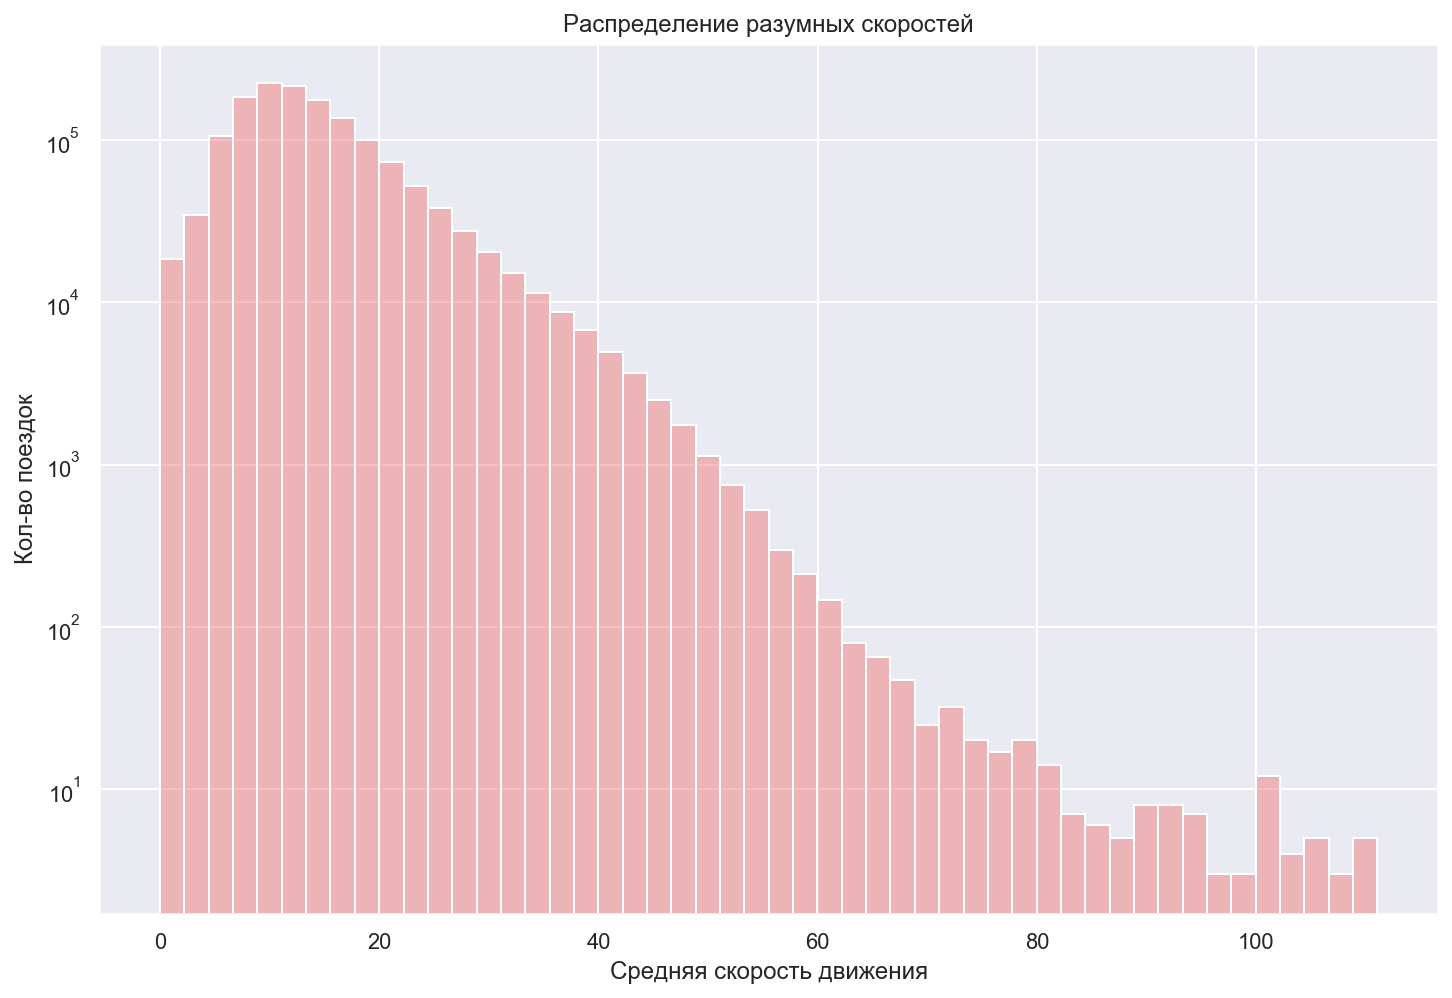

In [111]:
sns.histplot(x = taxi[taxi.speed < taxi.speed.quantile(0.9999)].speed, 
                 bins=50, alpha=0.5, color="lightcoral", log_scale=(False, True)).set_title('Распределение разумных скоростей')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12
plt.xlabel("Средняя скорость движения")
plt.ylabel("Кол-во поездок")
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

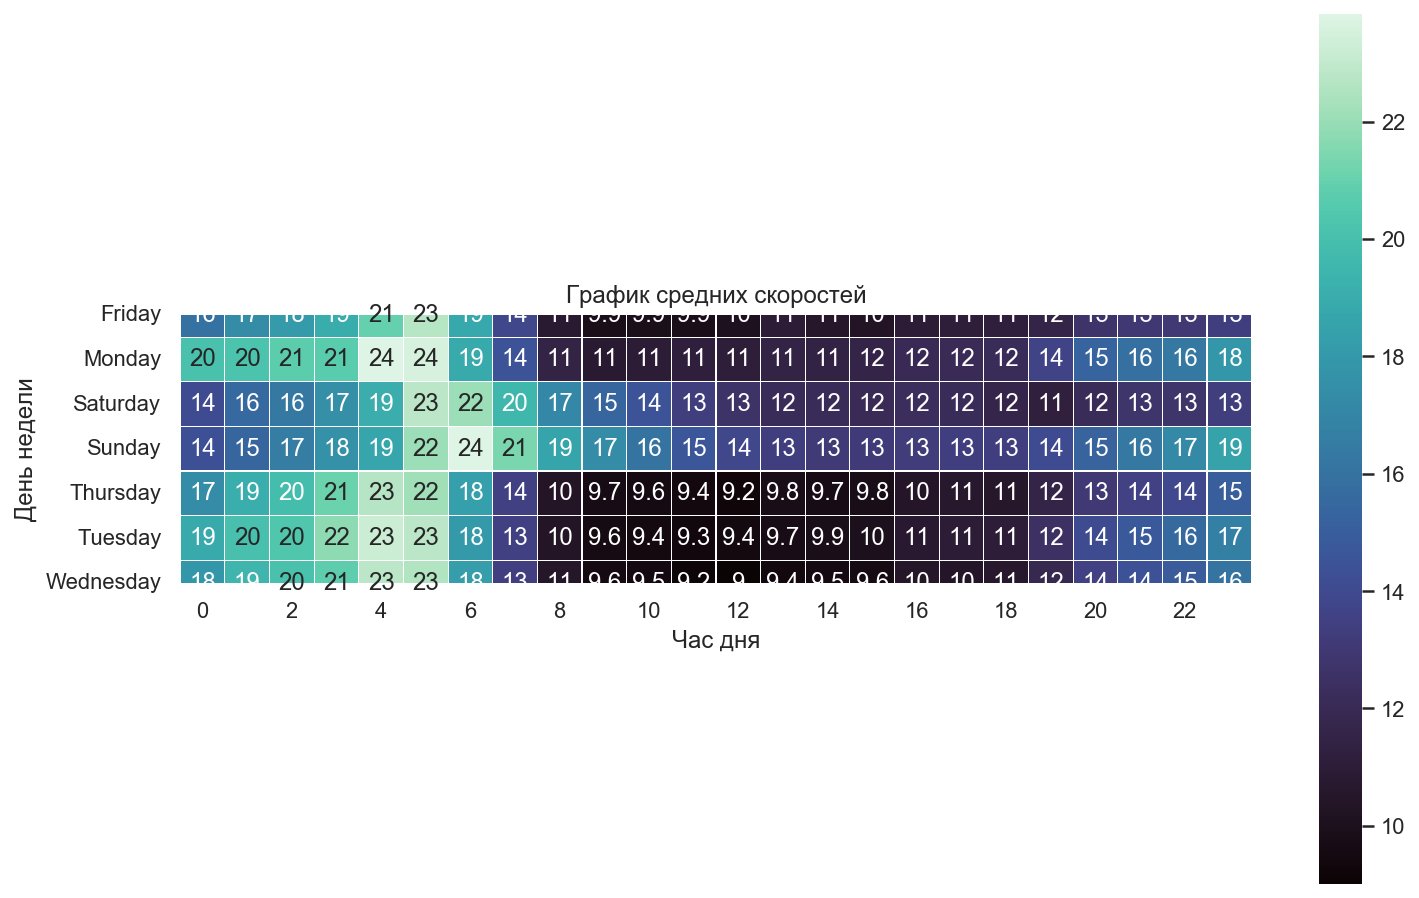

In [112]:
tmp = taxi.groupby(['week_day', 'hour']).median().reset_index()
sns.heatmap(tmp.pivot('week_day', 'hour', 'speed'), cmap='mako', square=True, linewidths=0.05, xticklabels=2, annot=True)
plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['font.size'] = 8
plt.xlabel("Час дня")
plt.ylabel("День недели")
plt.title("График средних скоростей")
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Скорее всего, причина в том, что корреляция, которую мы ранее выводили, между скоростью и таргетом крайне мала в абсолютных значениях.

In [113]:
taxi.drop('speed', axis=1, inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.


**Ответ**: Из графика видно, что скорость средняя наиболее велика примерно в одни и те же часы. Для будних этот промежуток с 1-2 до 6, для выходных - с 4 до 7-8. Это логично, ведь в эти часы наименьшая загруженность дорог, а значит, наибольшая возможность для скоростной езды. Напротив, с 9 до 15 в рабочие дни наблюдается минимальные значения медианы, минимальные значения выходных выстречаются с 13 до 18 (что, однако выше, чем минимумы будних).

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [114]:
# пнд - чт: [0, 6] - [7, 24]
# пт: [0] - [1, 6] - [7, 24]
# сб: [0, 3] - [4, 9] - [10, 24]
# вск: [0, 3] - [4, 9] - [10, 20] - [21, 24]

cond_free_all = (4 <= taxi.hour) & (taxi.hour <= 6)
cond_stop_all = (10 <= taxi.hour) & (taxi.hour <= 24)

cond_free_work = ((taxi.week_day != 'Sunday') & (taxi.week_day != 'Saturday')) & (0 <= taxi.hour) & (taxi.hour <= 4)
cond_stop_work = ((taxi.week_day != 'Sunday') & (taxi.week_day != 'Saturday')) & (7 <= taxi.hour) & (taxi.hour <= 10)
cond_stop_add = (taxi.week_day == 'Friday') & (taxi.hour == 0)

cond_free_end = ((taxi.week_day == 'Sunday') | (taxi.week_day == 'Saturday')) & (6 <= taxi.hour) & (taxi.hour <= 9)
cond_stop_end = ((taxi.week_day == 'Sunday') | (taxi.week_day == 'Saturday')) & (0 <= taxi.hour) & (taxi.hour <= 3)
cond_free_add = (taxi.week_day == 'Sunday') & (21 <= taxi.hour) & (taxi.hour <= 24)

taxi['free_road'] = (cond_free_all) | (cond_free_work) | (cond_free_end) | (cond_free_add)
taxi['jam_period'] = (cond_stop_all) | (cond_stop_work) | (cond_stop_end) | (cond_stop_add)

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [115]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='tutorial')
kenn_airport = geolocator.geocode("John F. Kennedy International Airport")
guard_airport = geolocator.geocode("LaGuardia Airport")

In [116]:
taxi['kenn_st'] = (taxi.pickup_latitude <= kenn_airport.latitude + 0.015) & (taxi.pickup_latitude >= kenn_airport.latitude - 0.015) & (taxi.pickup_longitude <= kenn_airport.longitude + 0.015)& (taxi.pickup_longitude >= kenn_airport.longitude - 0.015)
taxi['kenn_fin'] = (taxi.dropoff_latitude <= kenn_airport.latitude + 0.015) & (taxi.dropoff_latitude >= kenn_airport.latitude - 0.015) & (taxi.dropoff_longitude <= kenn_airport.longitude + 0.015)& (taxi.dropoff_longitude >= kenn_airport.longitude - 0.015)
taxi['guard_st'] = (taxi.pickup_latitude <= guard_airport.latitude + 0.015) & (taxi.pickup_latitude >= guard_airport.latitude - 0.015) & (taxi.pickup_longitude <= guard_airport.longitude + 0.015)& (taxi.pickup_longitude >= guard_airport.longitude - 0.015)
taxi['guard_fin'] = (taxi.dropoff_latitude <= guard_airport.latitude + 0.015) & (taxi.dropoff_latitude >= guard_airport.latitude - 0.015) & (taxi.dropoff_longitude <= guard_airport.longitude + 0.015)& (taxi.dropoff_longitude >= guard_airport.longitude - 0.015)

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

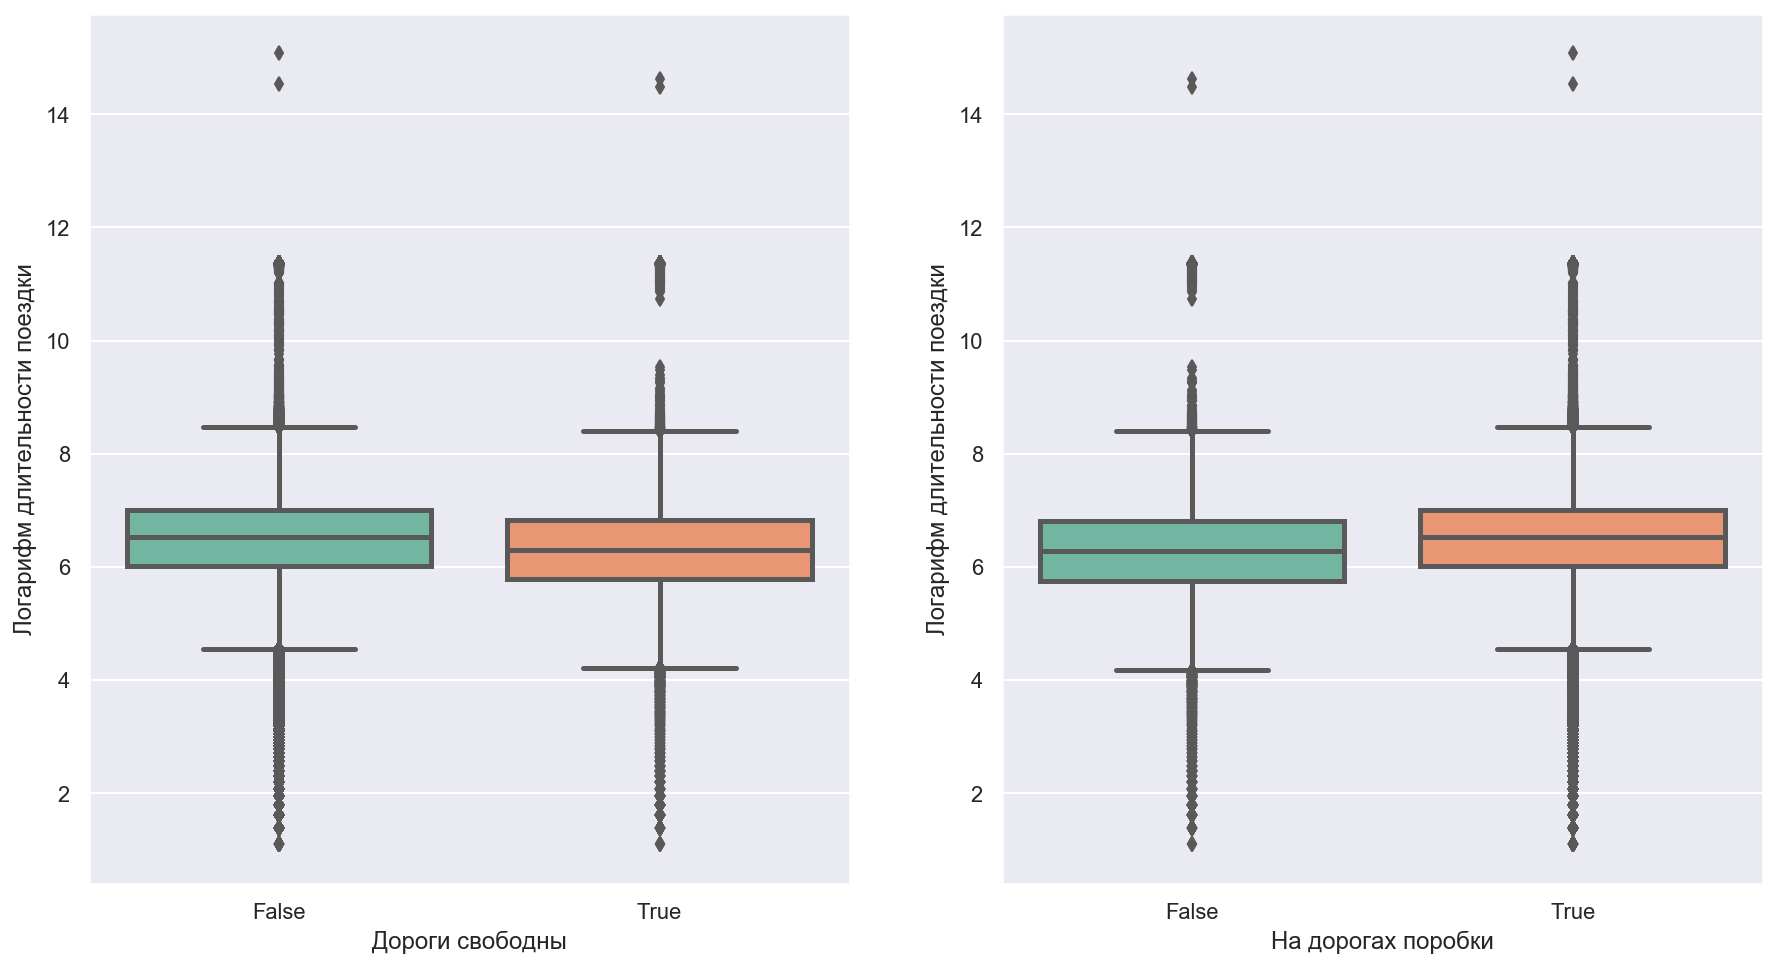

In [117]:
fig , ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 8))
sns.boxplot(ax=ax[0], data = taxi, x = 'free_road', y = 'log_trip_duration',palette="Set2", linewidth=2.5)
sns.boxplot(ax=ax[1], data = taxi, x = 'jam_period', y = 'log_trip_duration',palette="Set2", linewidth=2.5)
ax[0].set_xlabel("Дороги свободны")
ax[0].set_ylabel("Логарифм продолжительности поездки")
ax[1].set_xlabel("На дорогах поробки")
ax[1].set_ylabel("Логарифм продолжительности поездки")
plt.show()

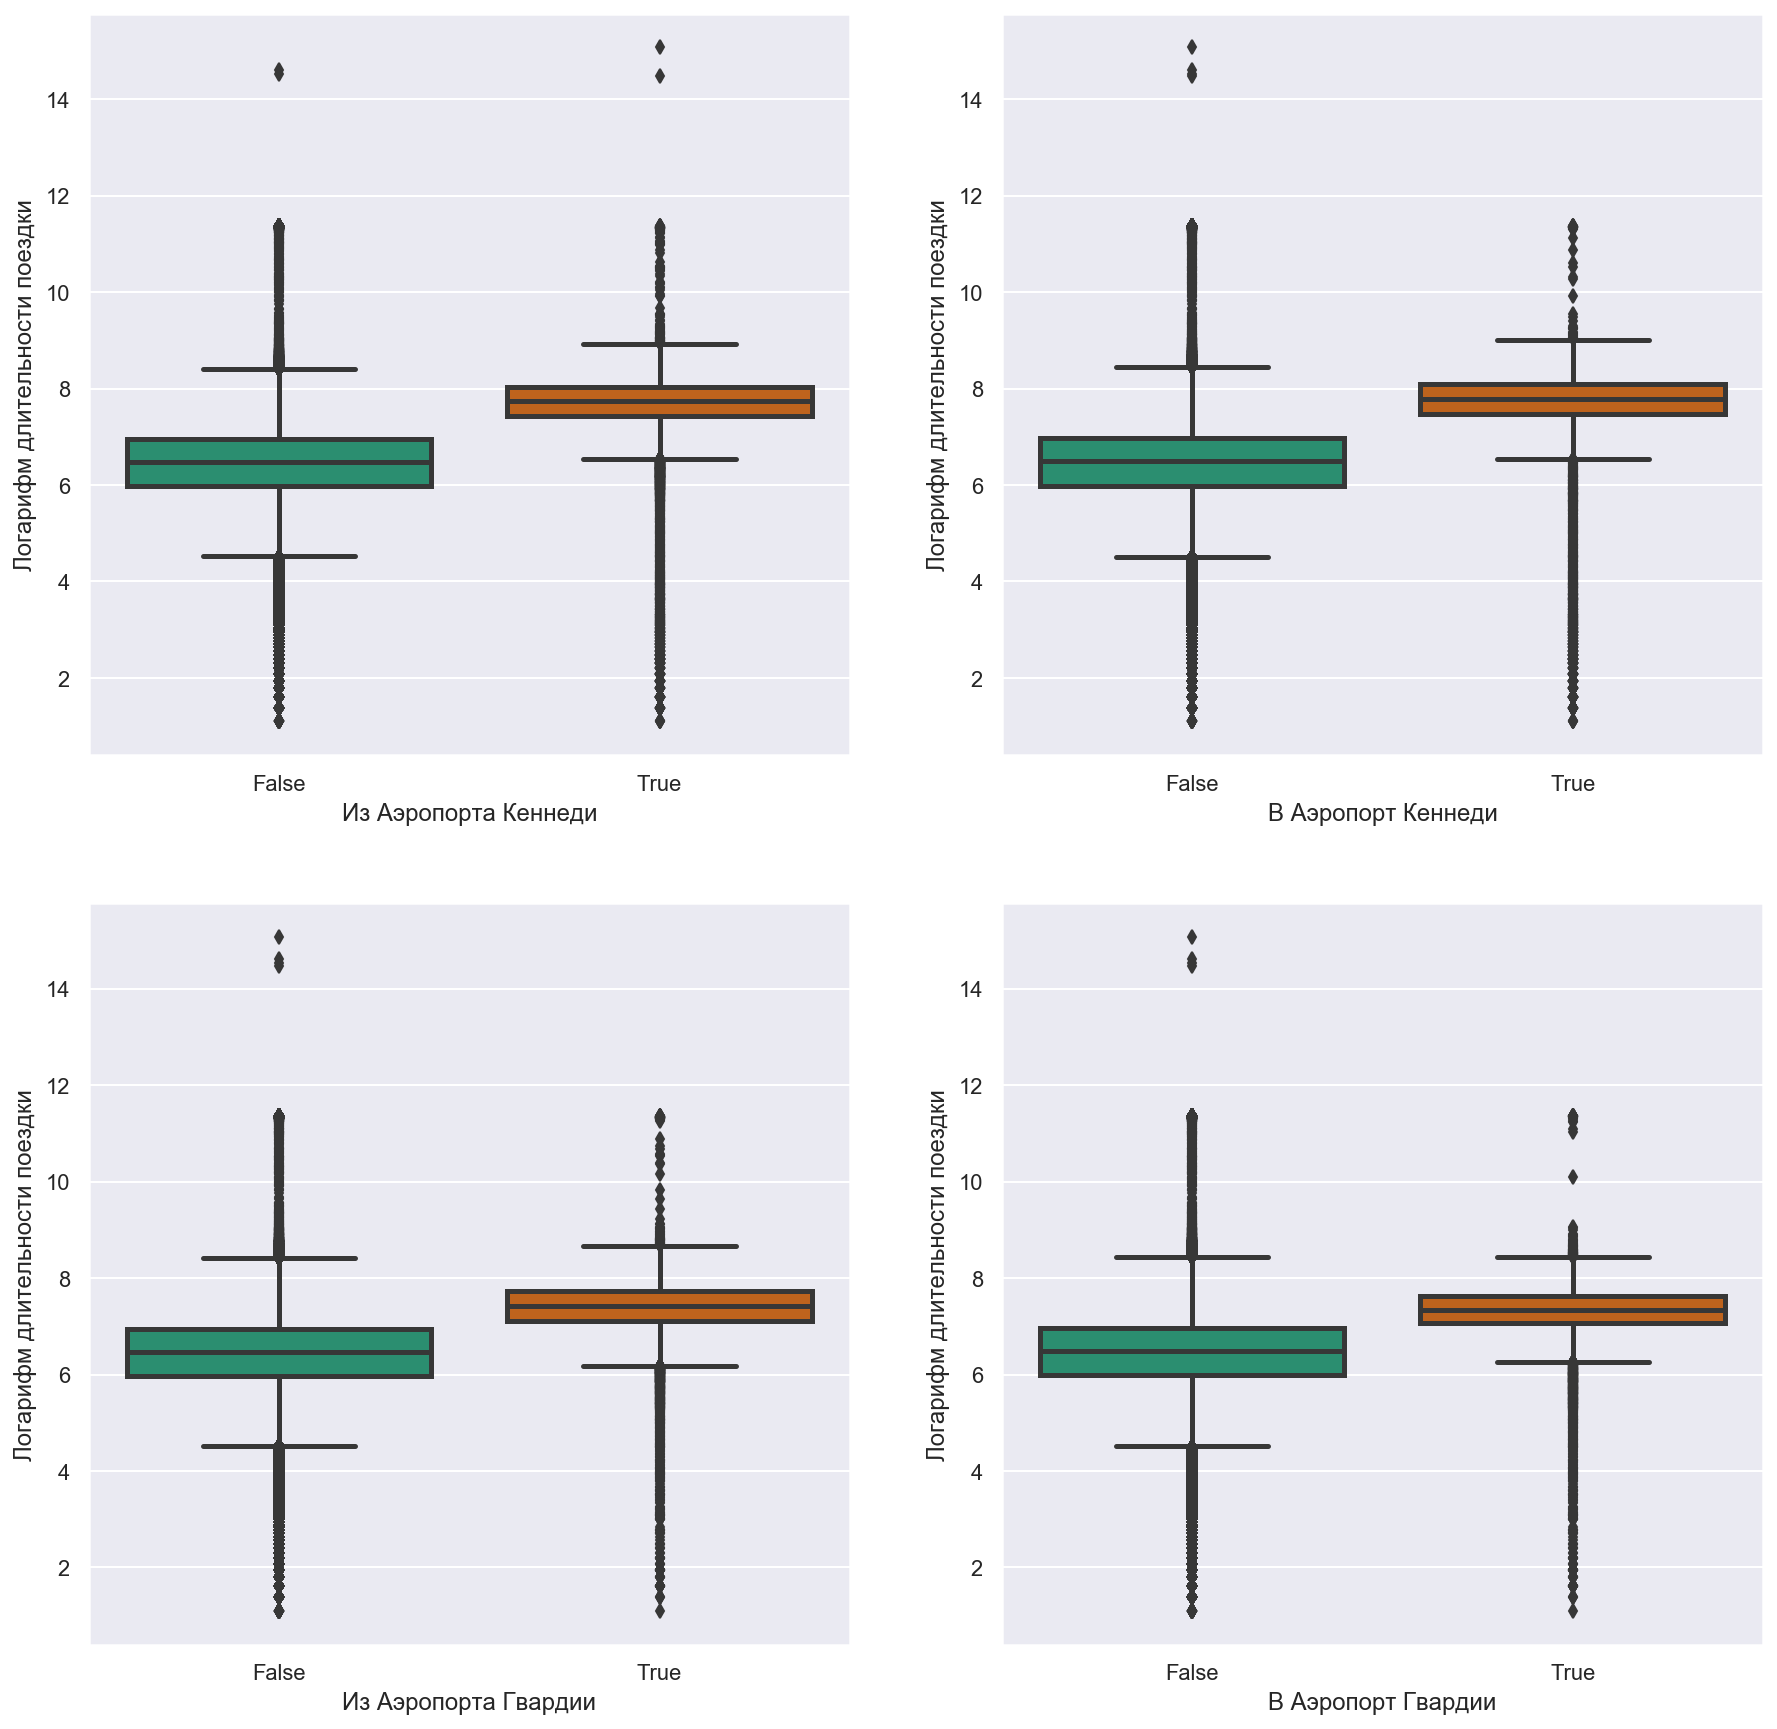

In [118]:
fig , ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,15))
sns.boxplot(ax=ax[0][0], data = taxi, x = 'kenn_st', y = 'log_trip_duration', palette="Dark2", linewidth=2.5)
sns.boxplot(ax=ax[0][1], data = taxi, x = 'kenn_fin', y = 'log_trip_duration', palette="Dark2", linewidth=2.5)
sns.boxplot(ax=ax[1][0], data = taxi, x = 'guard_st', y = 'log_trip_duration', palette="Dark2", linewidth=2.5)
sns.boxplot(ax=ax[1][1], data = taxi, x = 'guard_fin', y = 'log_trip_duration', palette="Dark2", linewidth=2.5)
ax[0][0].set_xlabel("Из Аэропорта Кеннеди")
ax[0][0].set_ylabel("Логарифм продолжительности поездки")
ax[0][1].set_xlabel("В Аэропорт Кеннеди")
ax[0][1].set_ylabel("Логарифм продолжительности поездки")
ax[1][0].set_xlabel("Из Аэропорта Гвардии")
ax[1][0].set_ylabel("Логарифм продолжительности поездки")
ax[1][1].set_xlabel("В Аэропорт Гвардии")
ax[1][1].set_ylabel("Логарифм продолжительности поездки")
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: Если говорить про графики для особых точек, можно указать на их высокое качество. Это напрямую следует из более высоких целевых значений для тех данных, которые включают в своем маршруте один из аэропортов. Таким образом, данный признак позволяет более грамотно оценивать таргет - продолжительность поездок.
Напротив, если обсуждать признак пробок, можно увидеть более близкие к друг другу графики (вообще, можно было обойтись одним boxplot вместо двух). Это свидетельствует о том, что целевая переменная не так сильно зависит от данного признака. Конечно, разница имеет место и значения все-таки разнятся,однако о меньшем эффекте свидетельствует контраст с ситуацией признаков аэропорта.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [119]:
#f = pd.concat([taxi.pickup_latitude, taxi.pickup_longitude], axis=1, keys=['lat','lon'])
#s = pd.concat([taxi.dropoff_latitude, taxi.dropoff_longitude], axis=1, keys=['lat','lon'])
#res = pd.concat([f, s])
#print(res.lat.quantile(0.05), res.lat.quantile(0.95))
#print(res.lon.quantile(0.05), res.lon.quantile(0.95))
#res = res[(res.lat >= res.lat.quantile(0.07)) & (res.lat <= res.lat.quantile(0.93)) &
#         (res.lon >= res.lon.quantile(0.07)) & (res.lon <= res.lon.quantile(0.93))]

40.7048454284668 40.79254913330078
-74.00720977783203 -73.91735076904298


In [120]:
#show_circles_on_map(taxi[taxi.pick_area == 12].sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [122]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, df):
        self.df = df
        pick = pd.concat([df.pickup_latitude, df.pickup_longitude], axis=1, keys=['lat','lon'])
        drop = pd.concat([df.dropoff_latitude, df.dropoff_longitude], axis=1, keys=['lat','lon'])
        self.total = pd.concat([pick, drop])
        self.total = self.total[(self.total.lat >= self.total.lat.quantile(0.07)) & 
                                (self.total.lat <= self.total.lat.quantile(0.93)) &
                                (self.total.lon >= self.total.lon.quantile(0.07)) & 
                                (self.total.lon <= self.total.lon.quantile(0.93))]
        self.left, self.right  = self.total.lon.min(), self.total.lon.max()
        self.up, self.down = self.total.lat.max(), self.total.lat.min() 
        self.hor_step = (self.right - self.left) / 3
        self.ver_step = (self.up - self.down) / 4
        
        
    def transform(self, taxi):  # я пробовал сделать функцию для двух циклов, но работало долго и очень плохо
        tmp = taxi.copy()
        tmp['pick_area'] = -1
        tmp['drop_area'] = -1
        for i in range(4):
            for j in range(3):
                tmp.loc[list(tmp[(self.left + self.hor_step * j <= tmp.pickup_longitude) & 
                   (self.left + self.hor_step * (j + 1) >= tmp.pickup_longitude) &
                   (self.up - self.ver_step * i >= tmp.pickup_latitude) & 
                   (self.up - self.ver_step * (i + 1) <= tmp.pickup_latitude)].index), 'pick_area'] = i * 3 + j + 1
                
        for i in range(4):
            for j in range(3):
                tmp.loc[list(tmp[(self.left + self.hor_step * j <= tmp.dropoff_longitude) & 
                   (self.left + self.hor_step * (j + 1) >= tmp.dropoff_longitude) &
                   (self.up - self.ver_step * i >= tmp.dropoff_latitude) & 
                   (self.up - self.ver_step * (i + 1) <= tmp.dropoff_latitude)].index), 'drop_area'] = i * 3 + j + 1
        return tmp

In [123]:
model = MapGridTransformer(taxi)
taxi = model.transform(taxi)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [126]:
x_train, x_test, y_train, y_test = train_test_split(taxi, taxi.log_trip_duration, test_size=0.3, random_state=10)
categorical = taxi.columns[11:15].tolist() + taxi.columns[25:27].tolist()
numeric_features = taxi.columns[15:17].tolist() + taxi.columns[18:19].tolist() + taxi.columns[21:25].tolist()

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train[categorical + numeric_features], y_train)
y_pred = model.predict(x_test[categorical + numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4724


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**: Теоретически, 'vendor_id' может указать на разницу в поездках, на которых специализируется таксопарк. Количество пассажиров может отразиться на продолжительности пути, так как для отдельных групп могут быть дополнительные точки. Флаг 'store_and_fwd_flag' может указывать на потенциальные выбросы, так как отсутсвие соединения с сервером подвергает сомнению достоверность данных.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [127]:
for col in ['vendor_id', 'passenger_count', 'store_and_fwd_flag']:
    print('Pattern named {0}'.format(col))
    print(display(pd.DataFrame(taxi[col].value_counts())))
    print()

Pattern named vendor_id


,vendor_id
2,780302
1,678342


None

Pattern named passenger_count


,passenger_count
1,1033540
2,210318
5,78088
3,59896
6,48333
4,28404
0,60
7,3
9,1
8,1


None

Pattern named store_and_fwd_flag


,store_and_fwd_flag
N,1450599
Y,8045


None



Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

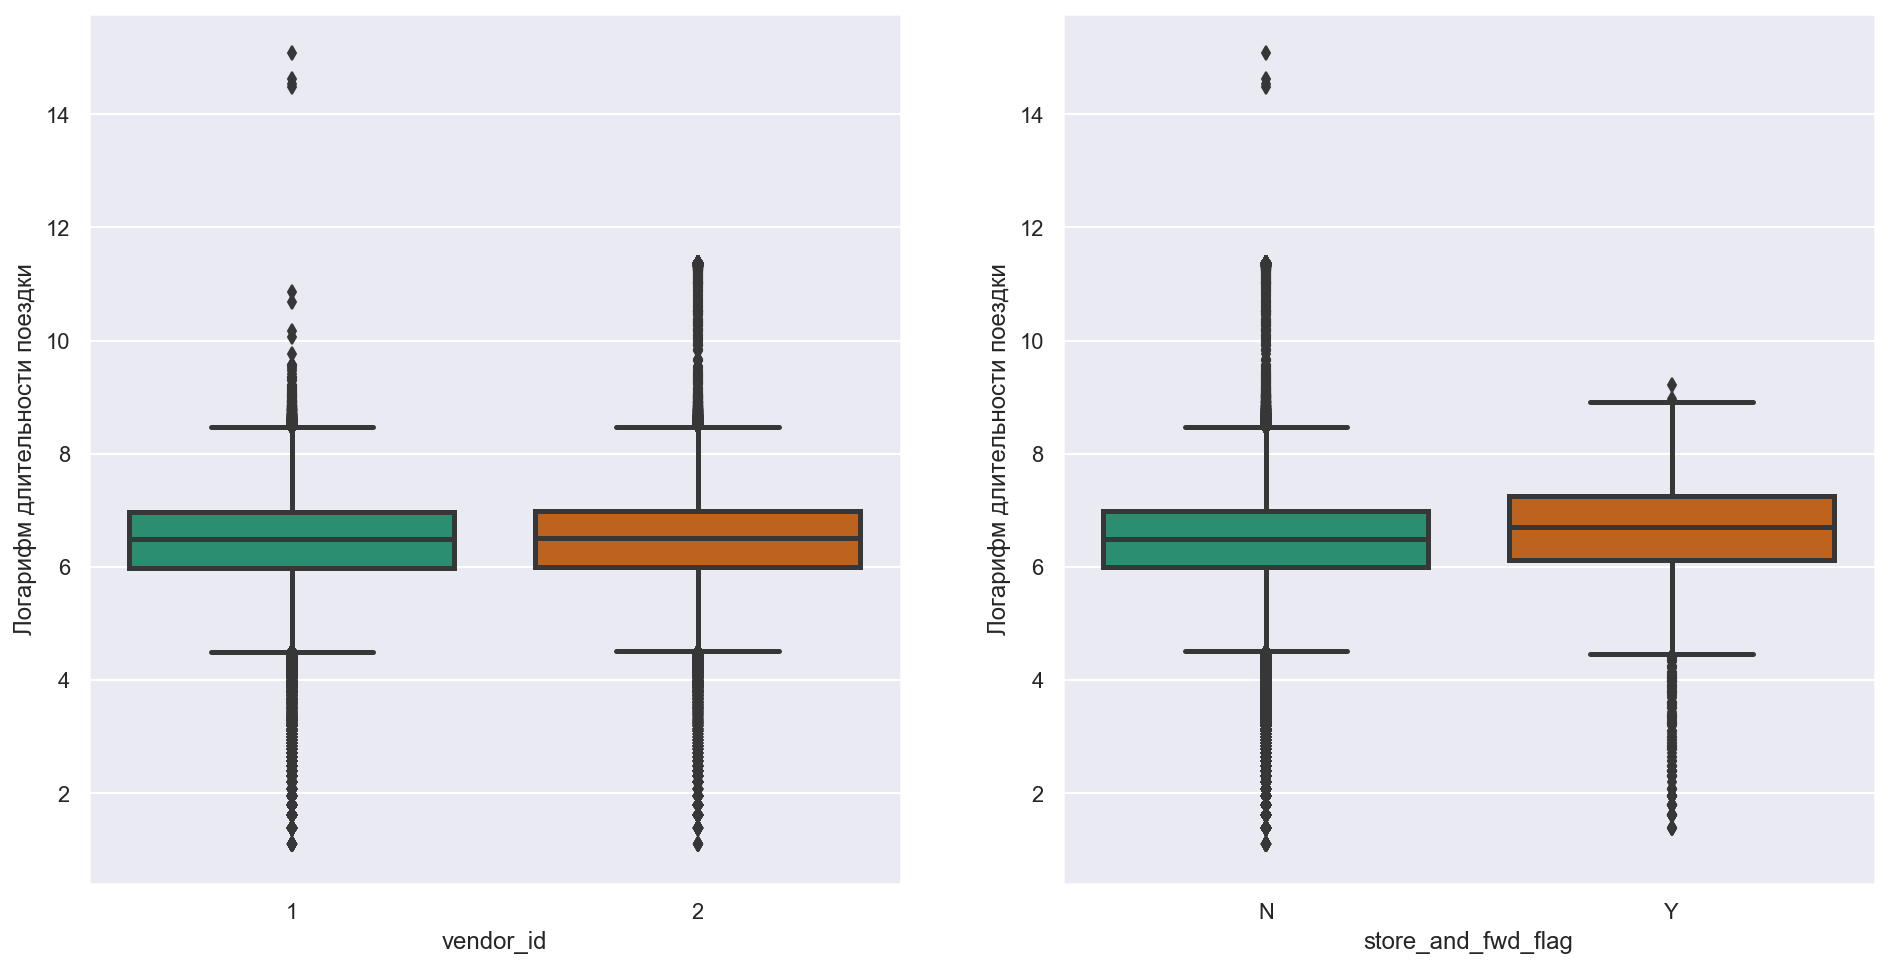

In [137]:
fig , ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,8))
sns.boxplot(ax=ax[0], data = taxi, x = 'vendor_id', y = 'log_trip_duration', palette="Dark2", linewidth=2.5)
sns.boxplot(ax=ax[1], data = taxi, x = 'store_and_fwd_flag', y = 'log_trip_duration', palette="Dark2", linewidth=2.5)
plt.rcParams['font.size'] = 8
ax[0].set_ylabel("Логарифм продолжительности поездки")
ax[1].set_ylabel("Логарифм продолжительности поездки")
plt.show()

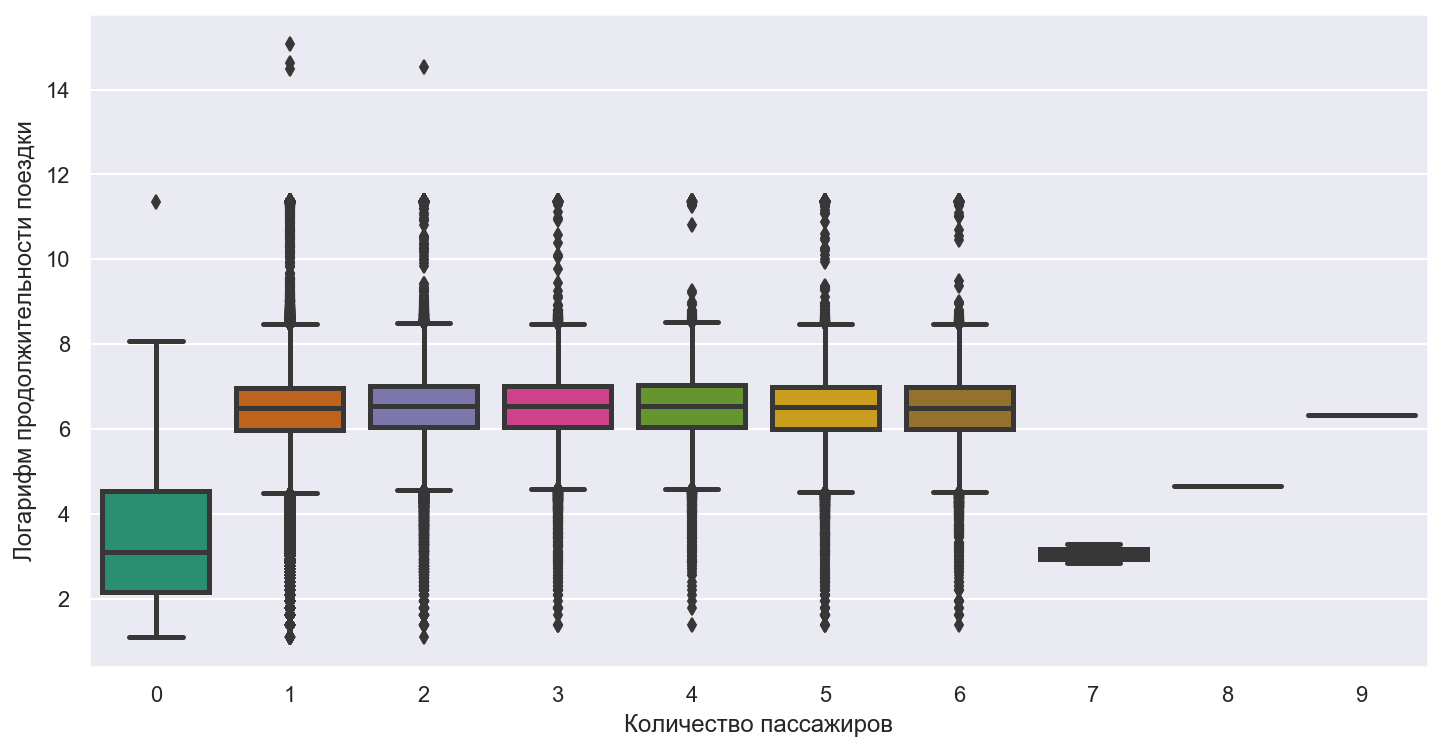

In [292]:
sns.boxplot(data = taxi, x = 'passenger_count', y = 'log_trip_duration', palette="Dark2", linewidth=2.5)
plt.rcParams['figure.figsize'] = 16, 10
plt.rcParams['font.size'] = 8
plt.xlabel("Количество пассажиров")
plt.ylabel("Логарифм продолжительности поездки")
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [138]:
taxi.store_and_fwd_flag = taxi.store_and_fwd_flag == 'Y'
taxi.vendor_id = taxi.vendor_id == 2

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: Графики первых двух boxplots иллюстрируют практически полную идентичность, что отчетливо указывает на низкую пользу признаков vendor_id и store_and_fwd_flag для нашей модели. Слегка другая ситуация в графике для числа пассажиров - среди схожик результатов для значений от 1 до 6 выделяется один особенный кейс - для 0 пассажиров. Внимание к этой особенности может незначительно улучшить нашу модель, однако к кардинальным изменениям не приведет.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [139]:
x_train, x_test, y_train, y_test = train_test_split(taxi, taxi.log_trip_duration, test_size=0.3, random_state=10)
categorical += taxi.columns[1:2].tolist() + taxi.columns[8:9].tolist()
numeric_features += taxi.columns[3:4].tolist()

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train[categorical + numeric_features], y_train)
y_pred = model.predict(x_test[categorical + numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4722


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [140]:
taxi['error'] = (y_train - model.predict(x_train)) ** 2

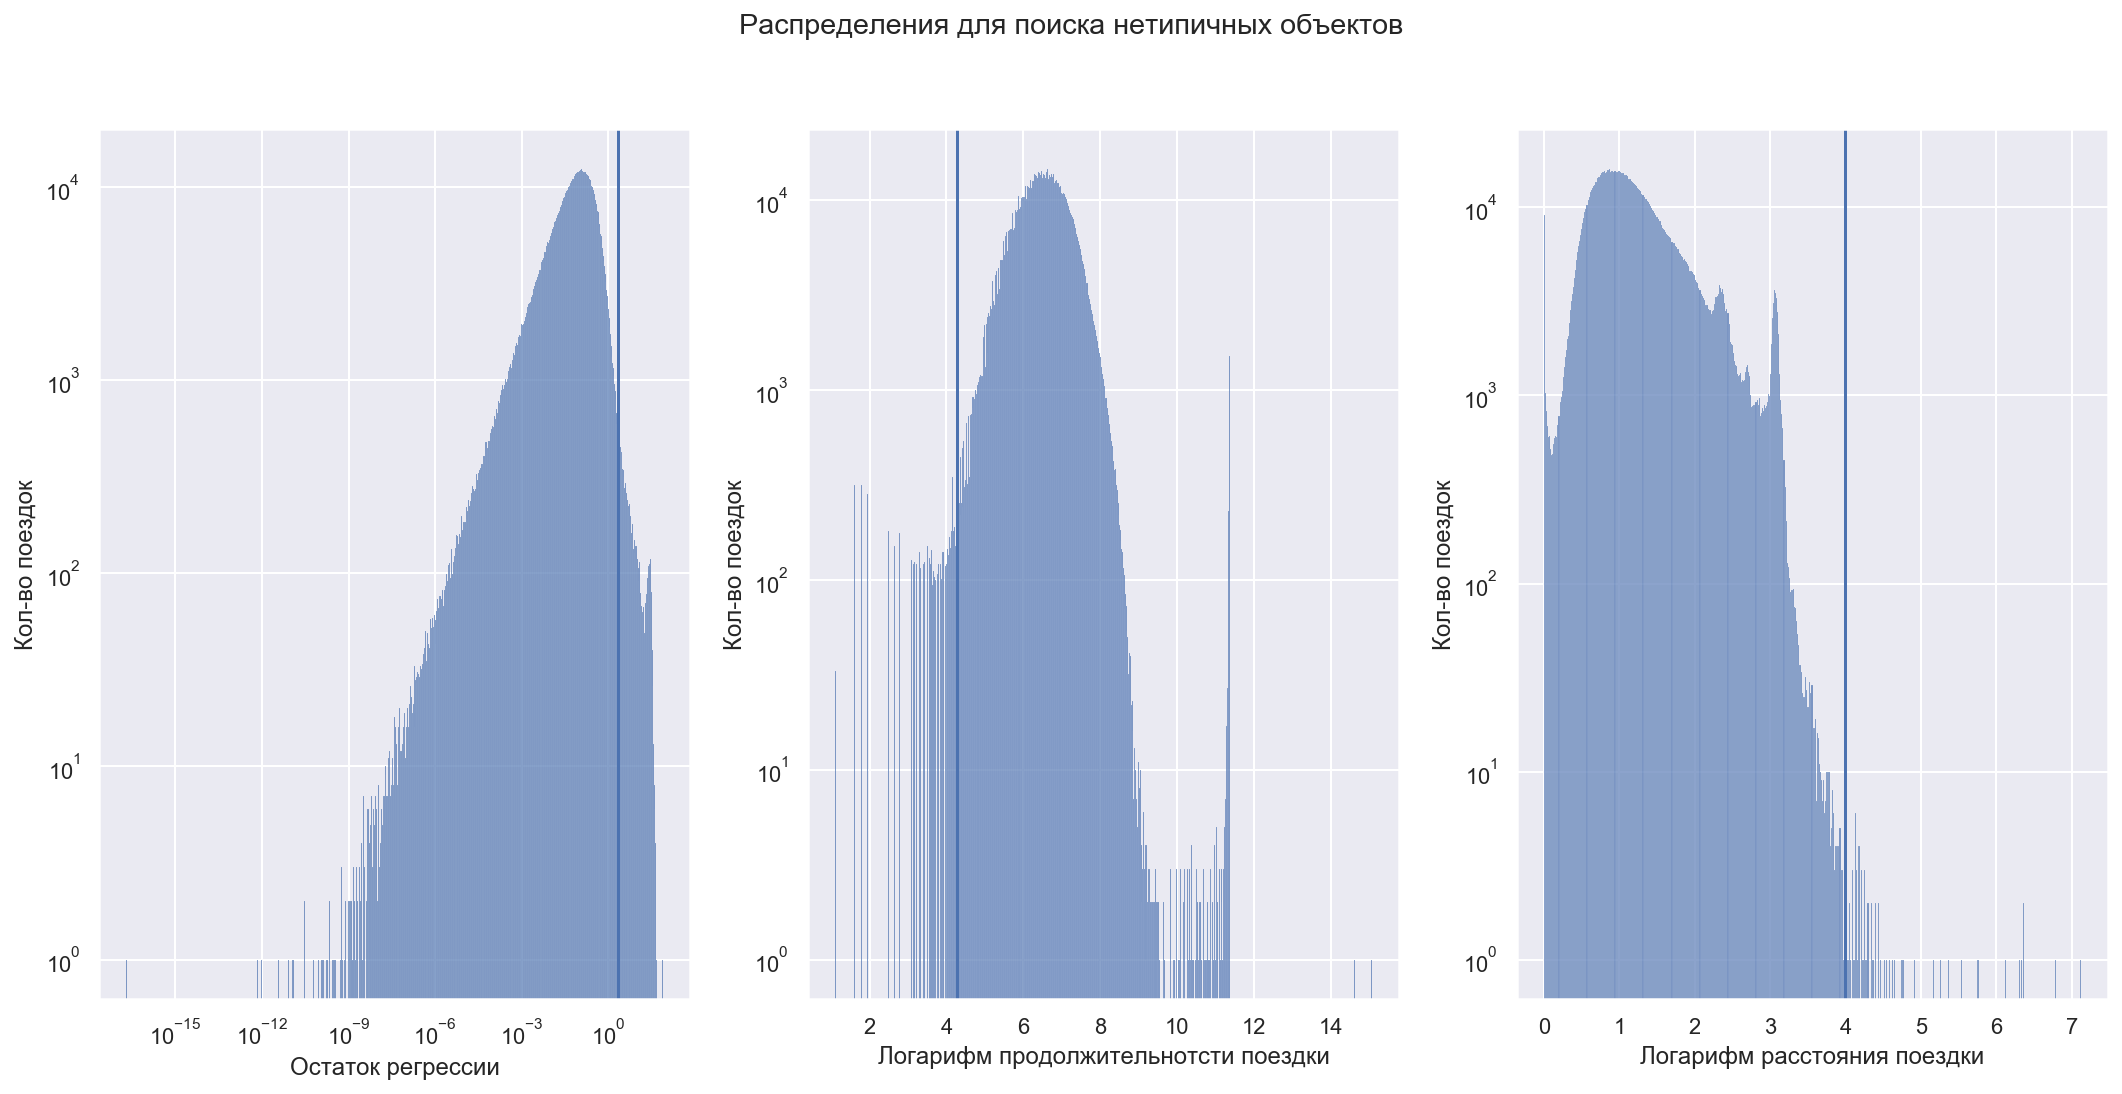

In [313]:
fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(18, 8))
fir = sns.histplot(x=taxi.error, log_scale=[True, True], ax=ax[0])
fir.axvline(x=taxi.error.quantile(0.99))
sec = sns.histplot(data=taxi, x='log_trip_duration', ax=ax[1], log_scale=[False, True])
sec.axvline(x=taxi.log_trip_duration.quantile(0.007))
thir = sns.histplot(data=taxi, x='log_haversine', ax=ax[2], log_scale=[False, True])
thir.axvline(x=taxi.log_haversine.quantile(0.99995))
ax[0].set_xlabel("Остаток регрессии")
ax[0].set_ylabel("Кол-во поездок")
ax[1].set_xlabel("Логарифм продолжительнотсти поездки")
ax[1].set_ylabel("Кол-во поездок")
ax[2].set_xlabel("Логарифм расстояния поездки")
ax[2].set_ylabel("Кол-во поездок")
plt.suptitle('Распределения для поиска нетипичных объектов')
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [142]:
taxi['airport_landing'] = taxi.kenn_st + taxi.guard_st
taxi['airport_departure'] = taxi.kenn_fin + taxi.guard_fin
taxi['anom'] = taxi.anom_1 + taxi.anom_2
holder = taxi.copy()
taxi.drop(['kenn_st', 'kenn_fin', 'guard_st', 'guard_fin', 'anom_1', 'anom_2'], axis=1, inplace=True)

/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [143]:
x_train, x_test, y_train, y_test = train_test_split(taxi, taxi.log_trip_duration, test_size=0.3, random_state=10)
x_train.drop(x_train[(x_train.error > x_train.error.quantile(0.999)) | (x_train.log_trip_duration < x_train.log_trip_duration.quantile(0.007))
         | (x_train.log_haversine > x_train.log_haversine.quantile(0.99995))].index, inplace=True)
y_train = x_train.log_trip_duration

Text(0, 0.5, 'Кол-во поездок')

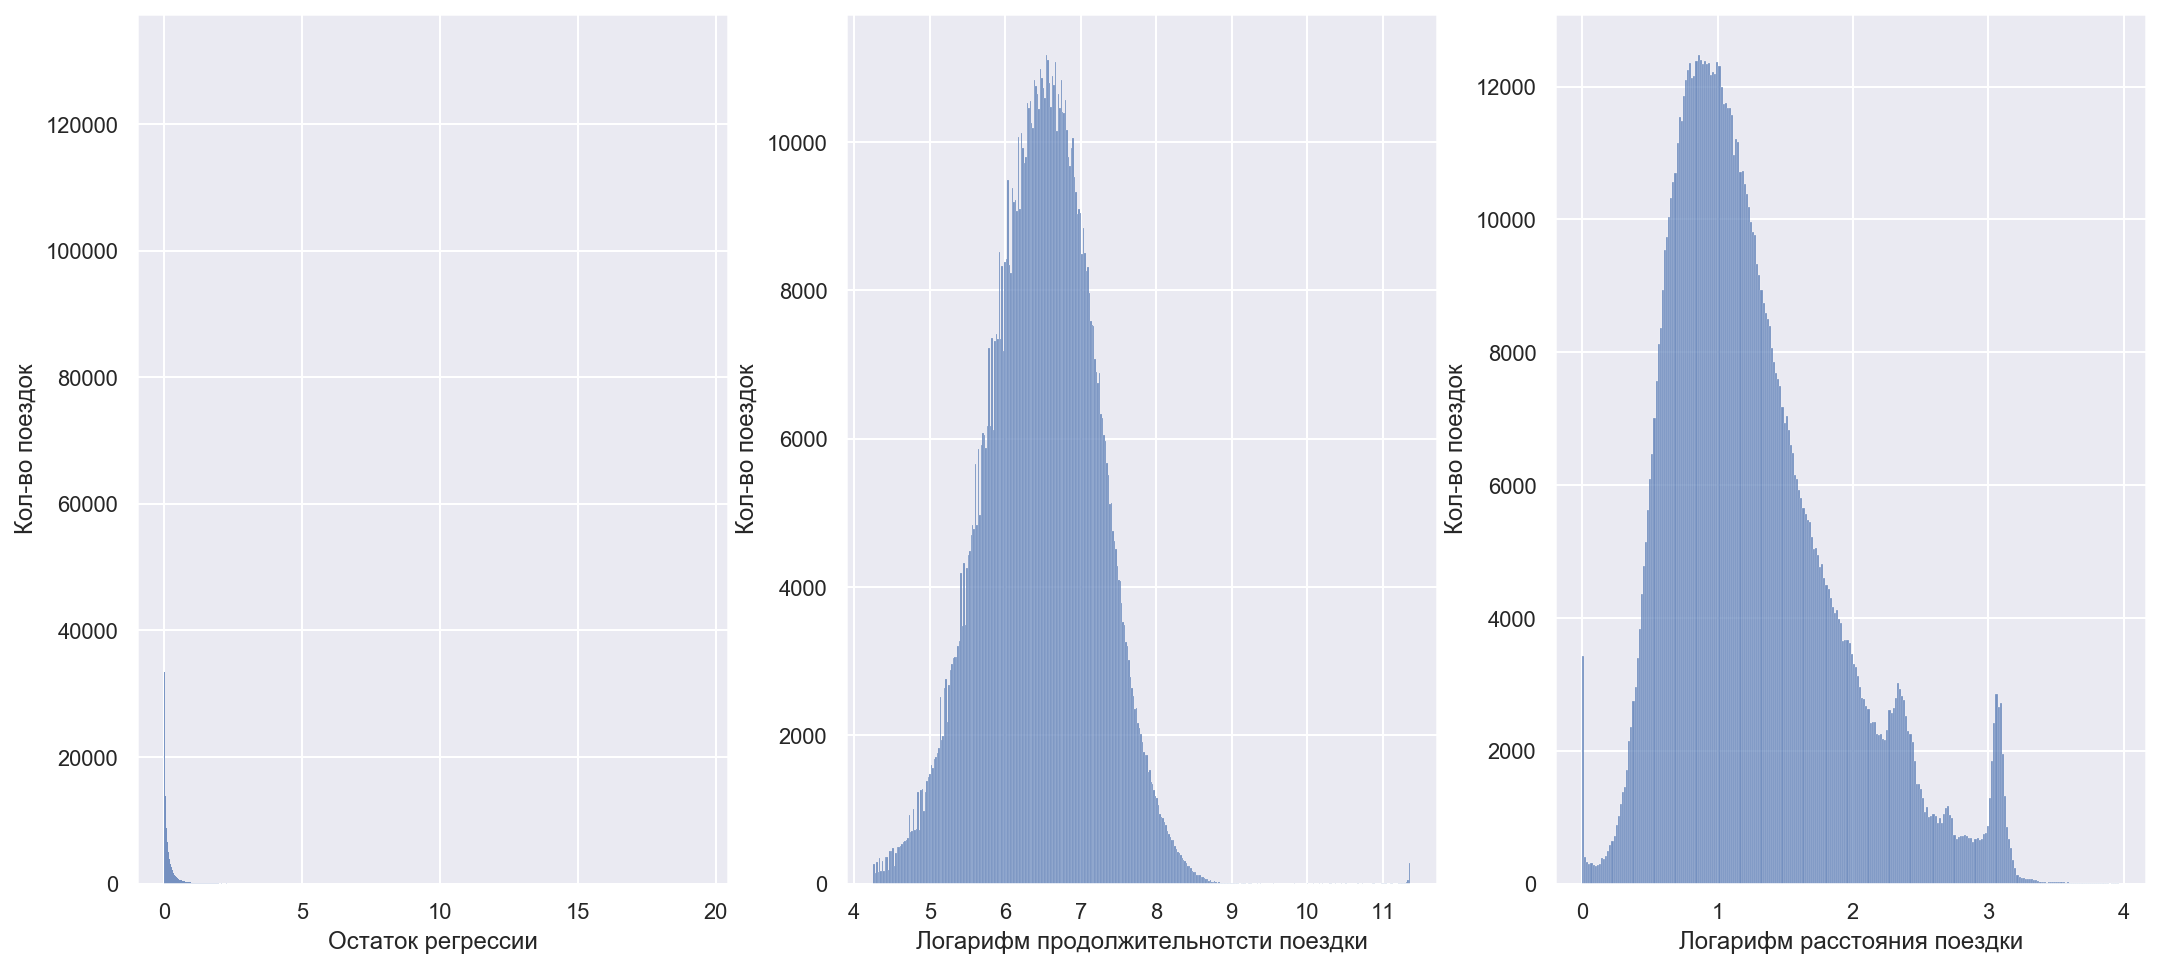

In [144]:
fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(18, 8))
fir = sns.histplot(x=x_train.error, ax=ax[0])
sec = sns.histplot(data=x_train, x='log_trip_duration', ax=ax[1])
thir = sns.histplot(data=x_train, x='log_haversine', ax=ax[2])
ax[0].set_xlabel("Остаток регрессии")
ax[0].set_ylabel("Кол-во поездок")
ax[1].set_xlabel("Логарифм продолжительнотсти поездки")
ax[1].set_ylabel("Кол-во поездок")
ax[2].set_xlabel("Логарифм расстояния поездки")
ax[2].set_ylabel("Кол-во поездок")
plt.suptitle('Вычищенные распределения')
plt.show()

In [145]:
categorical = x_train.columns[11:15].tolist() + x_train.columns[19:21].tolist()
numeric_features = x_train.columns[16:19].tolist() + x_train.columns[22:25].tolist()

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train[categorical + numeric_features], y_train)
y_pred = model.predict(x_test[categorical + numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4717


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [146]:
print('Before OHE -', taxi[categorical + numeric_features].shape[1], 'while after OHE -', 
      column_transformer.transform(x_train[categorical + numeric_features]).shape[1])

Before OHE - 12 while after OHE - 251


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

Из дальнейших вычислений увидим, что Lasso при данном раскладе хуже.

In [243]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(x_train[categorical + numeric_features], y_train)
y_pred = model.predict(x_test[categorical + numeric_features])
las_no_reg = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE = %.4f" % las_no_reg)

RMSE = 0.7911


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [198]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import random

x_train_scaled = column_transformer.fit_transform(x_train[numeric_features + categorical])
test_fold = [-1] * round(len(x_train) * 0.8) + [0] *  round(len(x_train) * 0.2)
random.shuffle(test_fold)
ps = PredefinedSplit(test_fold)

In [206]:
f
searcher_R = GridSearchCV(Ridge(), [{"alpha": alphas_R}], scoring="neg_root_mean_squared_error", cv=ps)
searcher_R.fit(x_train_scaled, y_train)
best_alpha_R = searcher_R.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha_R)

Best alpha = 75.4312


In [210]:
alphas_L = np.logspace(-4, -2, num=20)
searcher_L = GridSearchCV(Lasso(), [{"alpha": alphas_L}], scoring="neg_root_mean_squared_error", cv=ps)
searcher_L.fit(x_train_scaled, y_train)
best_alpha_L = searcher_L.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha_L)

Best alpha = 0.0001


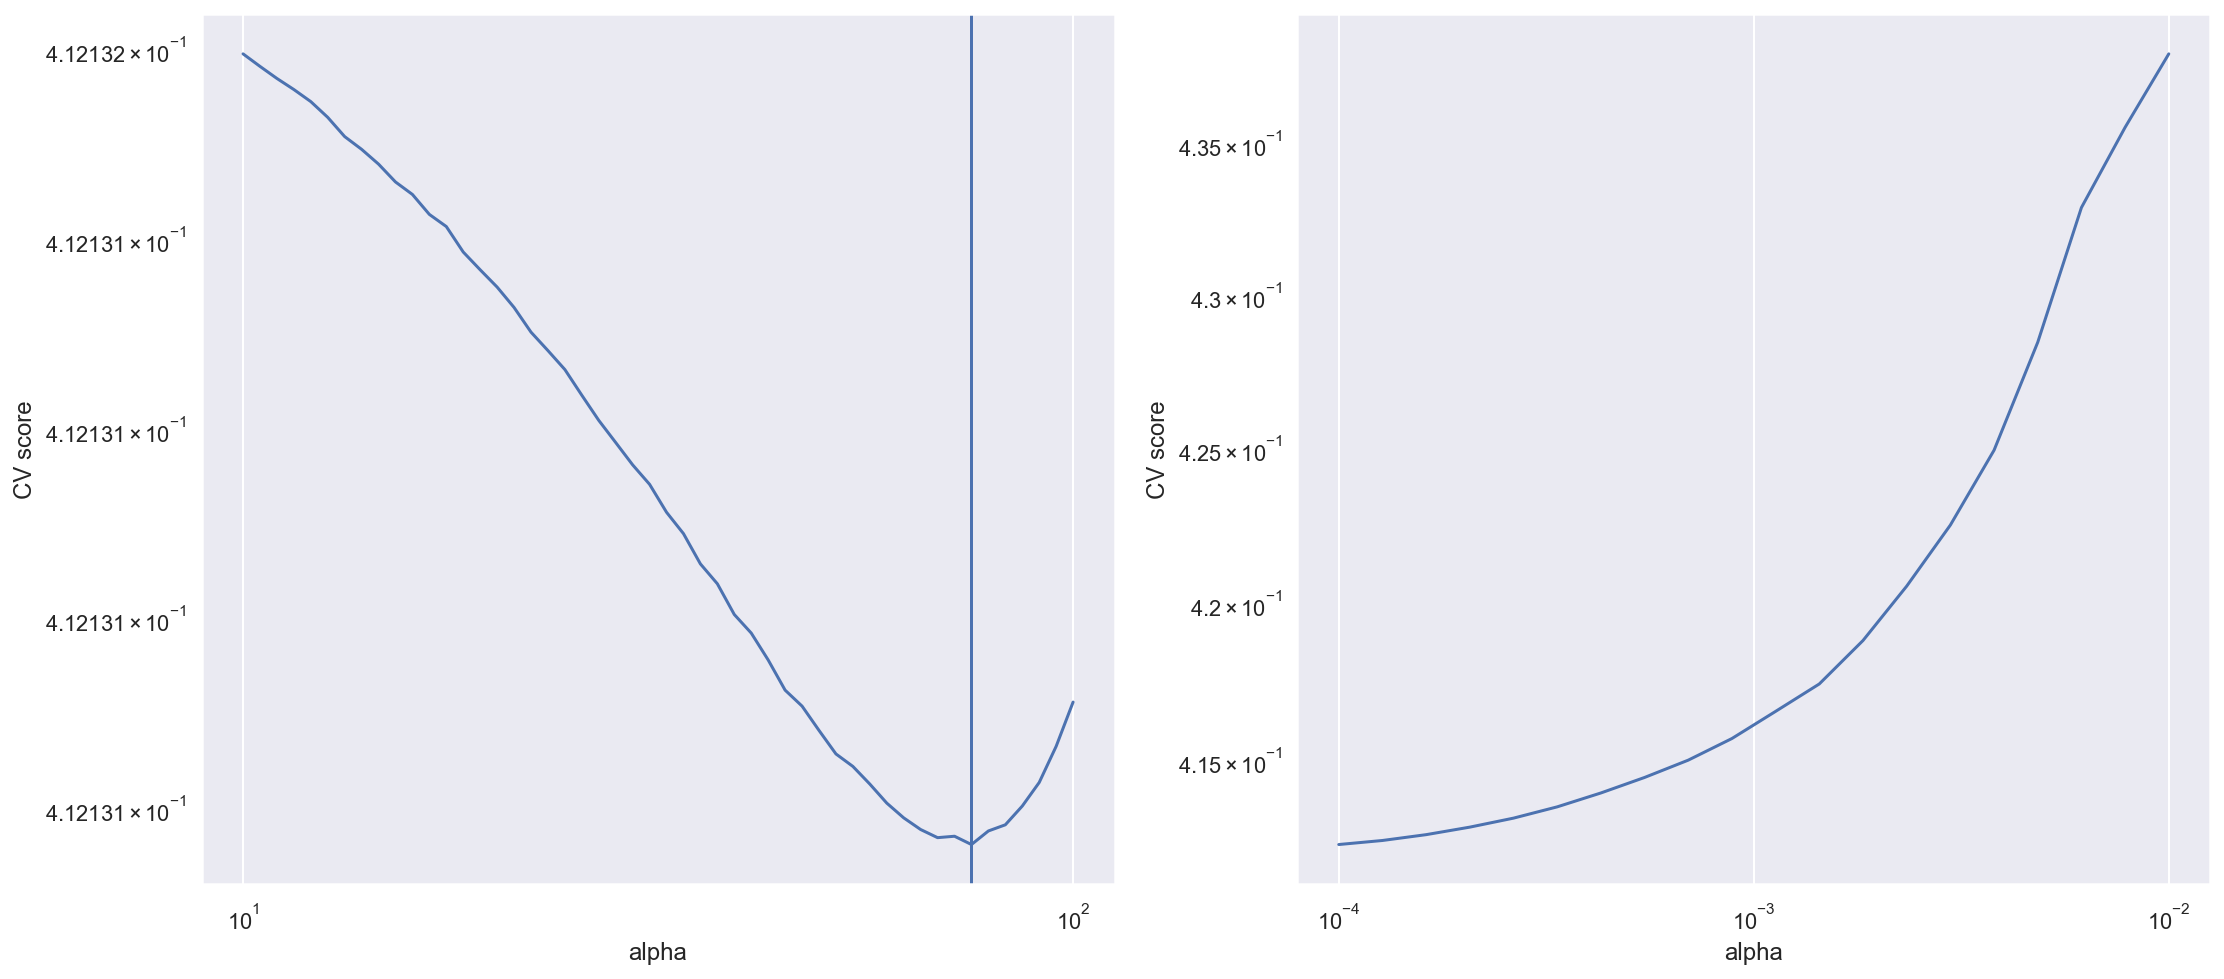

In [212]:
fig , ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 8))
ax[0].plot(alphas_R, -searcher_R.cv_results_["mean_test_score"])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("CV score")
ax[0].axvline(x=best_alpha_R)
ax[1].plot(alphas_L, -searcher_L.cv_results_["mean_test_score"])
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("CV score")
plt.show()

In [238]:
for train_ind, test_ind in ps.split():
    x_train_valid = x_train.iloc[train_ind]
y_train_valid = x_train_valid.log_trip_duration  
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha = best_alpha_R))
])

model = pipeline.fit(x_train_valid[categorical + numeric_features], y_train_valid)
y_pred = model.predict(x_test[categorical + numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4717


In [305]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha = best_alpha_L))
])

model = lasso_pipeline.fit(x_train_valid[categorical + numeric_features], y_train_valid)
y_pred = model.predict(x_test[categorical + numeric_features])
best_l = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE = %.4f" % best_l)

RMSE = 0.4719


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [219]:
y_axis = []
for al in alphas_L:
    pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha = al))
    ])
    ls = pipeline_lasso.fit(x_train[categorical + numeric_features], y_train)
    print('when alpha is equal to', al, "the number of zero weights is",
          sum(pipeline_lasso.steps[-1][-1].coef_ == 0))
    y_axis.append(sum(pipeline_lasso.steps[-1][-1].coef_ == 0))

when alpha is equal to 0.0001 the number of zero weights is 89
when alpha is equal to 0.00012742749857031334 the number of zero weights is 104
when alpha is equal to 0.0001623776739188721 the number of zero weights is 123
when alpha is equal to 0.00020691380811147902 the number of zero weights is 148
when alpha is equal to 0.00026366508987303583 the number of zero weights is 159
when alpha is equal to 0.0003359818286283781 the number of zero weights is 171
when alpha is equal to 0.00042813323987193956 the number of zero weights is 178
when alpha is equal to 0.000545559478116852 the number of zero weights is 186
when alpha is equal to 0.0006951927961775605 the number of zero weights is 192
when alpha is equal to 0.0008858667904100823 the number of zero weights is 193
when alpha is equal to 0.0011288378916846883 the number of zero weights is 198
when alpha is equal to 0.0014384498882876629 the number of zero weights is 201
when alpha is equal to 0.0018329807108324356 the number of zero w

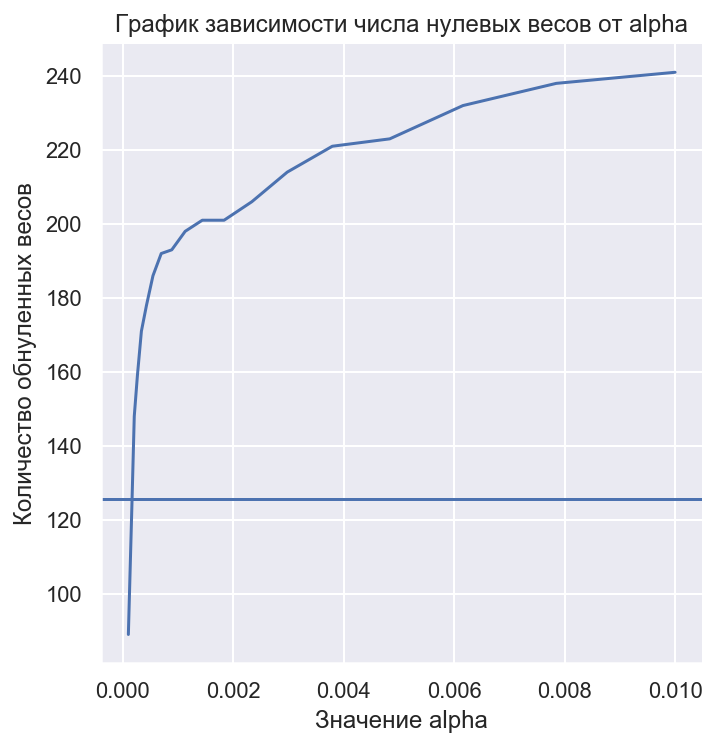

In [245]:
g = sns.relplot(x=alphas_L, y = y_axis, kind='line')
plt.xlabel('Значение alpha')
plt.ylabel('Количество обнуленных весов')
plt.title('График зависимости числа нулевых весов от alpha')
plt.axhline(y=column_transformer.transform(x_train[categorical + numeric_features]).shape[1] / 2)
al_med = np.interp(126, y_axis,alphas_L)

In [306]:
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha = al_med))
])

model = lasso_pipeline.fit(x_train_valid[categorical + numeric_features], y_train_valid)
y_pred = model.predict(x_test[categorical + numeric_features])
print(las_no_reg - mean_squared_error(y_test, y_pred, squared=False))
print(best_l - mean_squared_error(y_test, y_pred, squared=False))

0.3188969452880835
-0.0003182221811159902


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [278]:
checker = taxi[(taxi.drop_area != -1) & (taxi.pick_area != -1)]
checker = pd.DataFrame(checker.groupby(['pick_area', 'drop_area']).size().sort_values(0, ascending=False).head(100))
checker['st_fin'] = np.arange(checker.reset_index().shape[0])
tmp = taxi.copy()
taxi = taxi.merge(checker, on=['pick_area', 'drop_area'], how='left')

/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [286]:
x_train, x_test, y_train, y_test = train_test_split(taxi, taxi.log_trip_duration, test_size=0.3, random_state=10)
categorical2 = categorical + ['st_fin']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train[categorical2 + numeric_features], y_train)
y_pred = model.predict(x_test[categorical2 + numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4704


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.